In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0,
    'binarize'      : True,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_0


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4356408, 828)
(4356408, 7)
validation
(600264, 828)
(600264, 7)
test
(573544, 828)
(573544, 7)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 7)                 903       


Total params: 1538823 (5.87 MB)


Trainable params: 1538823 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/436 [..............................] - ETA: 12:20 - loss: 2.2156 - STD: 0.1253 - MAE: 0.2462

  4/436 [..............................] - ETA: 9s - loss: 2.0123 - STD: 0.0755 - MAE: 0.2425   

  7/436 [..............................] - ETA: 9s - loss: 1.9906 - STD: 0.0675 - MAE: 0.2421

 10/436 [..............................] - ETA: 9s - loss: 1.9793 - STD: 0.0617 - MAE: 0.2421

 13/436 [..............................] - ETA: 9s - loss: 1.9671 - STD: 0.0585 - MAE: 0.2419

 16/436 [>.............................] - ETA: 9s - loss: 1.9567 - STD: 0.0556 - MAE: 0.2418

 19/436 [>.............................] - ETA: 9s - loss: 1.9503 - STD: 0.0529 - MAE: 0.2418

 22/436 [>.............................] - ETA: 9s - loss: 1.9448 - STD: 0.0509 - MAE: 0.2418

 25/436 [>.............................] - ETA: 9s - loss: 1.9389 - STD: 0.0495 - MAE: 0.2417

 28/436 [>.............................] - ETA: 9s - loss: 1.9321 - STD: 0.0488 - MAE: 0.2415

 31/436 [=>............................] - ETA: 9s - loss: 1.9246 - STD: 0.0487 - MAE: 0.2412

 34/436 [=>............................] - ETA: 9s - loss: 1.9157 - STD: 0.0490 - MAE: 0.2407

 37/436 [=>............................] - ETA: 8s - loss: 1.9052 - STD: 0.0504 - MAE: 0.2401

 40/436 [=>............................] - ETA: 8s - loss: 1.8939 - STD: 0.0526 - MAE: 0.2393

 43/436 [=>............................] - ETA: 8s - loss: 1.8827 - STD: 0.0549 - MAE: 0.2385

 46/436 [==>...........................] - ETA: 8s - loss: 1.8716 - STD: 0.0570 - MAE: 0.2378

 49/436 [==>...........................] - ETA: 8s - loss: 1.8609 - STD: 0.0591 - MAE: 0.2370

 52/436 [==>...........................] - ETA: 8s - loss: 1.8505 - STD: 0.0613 - MAE: 0.2363

 55/436 [==>...........................] - ETA: 8s - loss: 1.8403 - STD: 0.0633 - MAE: 0.2356

 58/436 [==>...........................] - ETA: 8s - loss: 1.8303 - STD: 0.0653 - MAE: 0.2348

 61/436 [===>..........................] - ETA: 8s - loss: 1.8212 - STD: 0.0671 - MAE: 0.2342

 64/436 [===>..........................] - ETA: 8s - loss: 1.8121 - STD: 0.0688 - MAE: 0.2335

 67/436 [===>..........................] - ETA: 8s - loss: 1.8031 - STD: 0.0706 - MAE: 0.2328

 70/436 [===>..........................] - ETA: 8s - loss: 1.7943 - STD: 0.0723 - MAE: 0.2321

 73/436 [====>.........................] - ETA: 8s - loss: 1.7855 - STD: 0.0740 - MAE: 0.2315

 76/436 [====>.........................] - ETA: 8s - loss: 1.7765 - STD: 0.0757 - MAE: 0.2308

 79/436 [====>.........................] - ETA: 8s - loss: 1.7672 - STD: 0.0772 - MAE: 0.2301

 82/436 [====>.........................] - ETA: 7s - loss: 1.7578 - STD: 0.0788 - MAE: 0.2294

 85/436 [====>.........................] - ETA: 7s - loss: 1.7482 - STD: 0.0803 - MAE: 0.2287

 88/436 [=====>........................] - ETA: 7s - loss: 1.7382 - STD: 0.0818 - MAE: 0.2280

 91/436 [=====>........................] - ETA: 7s - loss: 1.7281 - STD: 0.0835 - MAE: 0.2272

 94/436 [=====>........................] - ETA: 7s - loss: 1.7174 - STD: 0.0852 - MAE: 0.2264

 97/436 [=====>........................] - ETA: 7s - loss: 1.7066 - STD: 0.0870 - MAE: 0.2255

100/436 [=====>........................] - ETA: 7s - loss: 1.6961 - STD: 0.0889 - MAE: 0.2246

103/436 [======>.......................] - ETA: 7s - loss: 1.6856 - STD: 0.0907 - MAE: 0.2237

106/436 [======>.......................] - ETA: 7s - loss: 1.6752 - STD: 0.0926 - MAE: 0.2228

109/436 [======>.......................] - ETA: 7s - loss: 1.6655 - STD: 0.0944 - MAE: 0.2220

112/436 [======>.......................] - ETA: 7s - loss: 1.6557 - STD: 0.0962 - MAE: 0.2211

115/436 [======>.......................] - ETA: 7s - loss: 1.6459 - STD: 0.0981 - MAE: 0.2202

118/436 [=======>......................] - ETA: 7s - loss: 1.6366 - STD: 0.0998 - MAE: 0.2194

121/436 [=======>......................] - ETA: 7s - loss: 1.6273 - STD: 0.1015 - MAE: 0.2185

124/436 [=======>......................] - ETA: 6s - loss: 1.6184 - STD: 0.1032 - MAE: 0.2177

127/436 [=======>......................] - ETA: 6s - loss: 1.6098 - STD: 0.1048 - MAE: 0.2169

130/436 [=======>......................] - ETA: 6s - loss: 1.6014 - STD: 0.1063 - MAE: 0.2161

133/436 [========>.....................] - ETA: 6s - loss: 1.5932 - STD: 0.1078 - MAE: 0.2154

136/436 [========>.....................] - ETA: 6s - loss: 1.5852 - STD: 0.1093 - MAE: 0.2146

139/436 [========>.....................] - ETA: 6s - loss: 1.5775 - STD: 0.1107 - MAE: 0.2139

142/436 [========>.....................] - ETA: 6s - loss: 1.5698 - STD: 0.1121 - MAE: 0.2132

145/436 [========>.....................] - ETA: 6s - loss: 1.5623 - STD: 0.1134 - MAE: 0.2125

148/436 [=========>....................] - ETA: 6s - loss: 1.5553 - STD: 0.1147 - MAE: 0.2118

151/436 [=========>....................] - ETA: 6s - loss: 1.5484 - STD: 0.1160 - MAE: 0.2111

154/436 [=========>....................] - ETA: 6s - loss: 1.5416 - STD: 0.1172 - MAE: 0.2105

157/436 [=========>....................] - ETA: 6s - loss: 1.5351 - STD: 0.1184 - MAE: 0.2099

160/436 [==========>...................] - ETA: 6s - loss: 1.5287 - STD: 0.1196 - MAE: 0.2092

163/436 [==========>...................] - ETA: 6s - loss: 1.5225 - STD: 0.1207 - MAE: 0.2086

166/436 [==========>...................] - ETA: 6s - loss: 1.5164 - STD: 0.1218 - MAE: 0.2081

169/436 [==========>...................] - ETA: 5s - loss: 1.5104 - STD: 0.1229 - MAE: 0.2075

172/436 [==========>...................] - ETA: 5s - loss: 1.5047 - STD: 0.1240 - MAE: 0.2069

175/436 [===========>..................] - ETA: 5s - loss: 1.4991 - STD: 0.1250 - MAE: 0.2064

178/436 [===========>..................] - ETA: 5s - loss: 1.4934 - STD: 0.1260 - MAE: 0.2058

181/436 [===========>..................] - ETA: 5s - loss: 1.4879 - STD: 0.1270 - MAE: 0.2053

184/436 [===========>..................] - ETA: 5s - loss: 1.4828 - STD: 0.1280 - MAE: 0.2047

187/436 [===========>..................] - ETA: 5s - loss: 1.4776 - STD: 0.1289 - MAE: 0.2042

190/436 [============>.................] - ETA: 5s - loss: 1.4725 - STD: 0.1298 - MAE: 0.2037

193/436 [============>.................] - ETA: 5s - loss: 1.4675 - STD: 0.1307 - MAE: 0.2032

196/436 [============>.................] - ETA: 5s - loss: 1.4627 - STD: 0.1316 - MAE: 0.2028

199/436 [============>.................] - ETA: 5s - loss: 1.4580 - STD: 0.1325 - MAE: 0.2023

202/436 [============>.................] - ETA: 5s - loss: 1.4533 - STD: 0.1333 - MAE: 0.2018

205/436 [=============>................] - ETA: 5s - loss: 1.4488 - STD: 0.1342 - MAE: 0.2013

208/436 [=============>................] - ETA: 5s - loss: 1.4442 - STD: 0.1350 - MAE: 0.2009

211/436 [=============>................] - ETA: 5s - loss: 1.4398 - STD: 0.1358 - MAE: 0.2004

214/436 [=============>................] - ETA: 4s - loss: 1.4353 - STD: 0.1366 - MAE: 0.2000

217/436 [=============>................] - ETA: 4s - loss: 1.4311 - STD: 0.1373 - MAE: 0.1996

220/436 [==============>...............] - ETA: 4s - loss: 1.4269 - STD: 0.1381 - MAE: 0.1991

223/436 [==============>...............] - ETA: 4s - loss: 1.4228 - STD: 0.1388 - MAE: 0.1987

226/436 [==============>...............] - ETA: 5s - loss: 1.4192 - STD: 0.1396 - MAE: 0.1983

229/436 [==============>...............] - ETA: 5s - loss: 1.4154 - STD: 0.1403 - MAE: 0.1979

232/436 [==============>...............] - ETA: 5s - loss: 1.4115 - STD: 0.1410 - MAE: 0.1975

235/436 [===============>..............] - ETA: 5s - loss: 1.4077 - STD: 0.1417 - MAE: 0.1971

238/436 [===============>..............] - ETA: 5s - loss: 1.4040 - STD: 0.1424 - MAE: 0.1967

241/436 [===============>..............] - ETA: 5s - loss: 1.4005 - STD: 0.1430 - MAE: 0.1963

244/436 [===============>..............] - ETA: 5s - loss: 1.3970 - STD: 0.1437 - MAE: 0.1960

247/436 [===============>..............] - ETA: 4s - loss: 1.3934 - STD: 0.1443 - MAE: 0.1956

250/436 [================>.............] - ETA: 4s - loss: 1.3899 - STD: 0.1449 - MAE: 0.1952

253/436 [================>.............] - ETA: 4s - loss: 1.3864 - STD: 0.1456 - MAE: 0.1949

256/436 [================>.............] - ETA: 4s - loss: 1.3831 - STD: 0.1462 - MAE: 0.1945

259/436 [================>.............] - ETA: 4s - loss: 1.3798 - STD: 0.1468 - MAE: 0.1942

262/436 [=================>............] - ETA: 4s - loss: 1.3766 - STD: 0.1474 - MAE: 0.1938

265/436 [=================>............] - ETA: 4s - loss: 1.3734 - STD: 0.1480 - MAE: 0.1935

268/436 [=================>............] - ETA: 4s - loss: 1.3703 - STD: 0.1485 - MAE: 0.1932

271/436 [=================>............] - ETA: 4s - loss: 1.3673 - STD: 0.1491 - MAE: 0.1929

274/436 [=================>............] - ETA: 4s - loss: 1.3642 - STD: 0.1496 - MAE: 0.1925

277/436 [==================>...........] - ETA: 4s - loss: 1.3612 - STD: 0.1502 - MAE: 0.1922

280/436 [==================>...........] - ETA: 4s - loss: 1.3583 - STD: 0.1507 - MAE: 0.1919

283/436 [==================>...........] - ETA: 3s - loss: 1.3556 - STD: 0.1512 - MAE: 0.1916

286/436 [==================>...........] - ETA: 3s - loss: 1.3527 - STD: 0.1517 - MAE: 0.1913

289/436 [==================>...........] - ETA: 3s - loss: 1.3498 - STD: 0.1523 - MAE: 0.1910

292/436 [===================>..........] - ETA: 3s - loss: 1.3471 - STD: 0.1528 - MAE: 0.1907

295/436 [===================>..........] - ETA: 3s - loss: 1.3443 - STD: 0.1533 - MAE: 0.1904

298/436 [===================>..........] - ETA: 3s - loss: 1.3418 - STD: 0.1538 - MAE: 0.1901

301/436 [===================>..........] - ETA: 3s - loss: 1.3390 - STD: 0.1542 - MAE: 0.1898

304/436 [===================>..........] - ETA: 3s - loss: 1.3364 - STD: 0.1547 - MAE: 0.1896

307/436 [====================>.........] - ETA: 3s - loss: 1.3339 - STD: 0.1552 - MAE: 0.1893

310/436 [====================>.........] - ETA: 3s - loss: 1.3314 - STD: 0.1556 - MAE: 0.1890

313/436 [====================>.........] - ETA: 3s - loss: 1.3289 - STD: 0.1561 - MAE: 0.1887

316/436 [====================>.........] - ETA: 3s - loss: 1.3265 - STD: 0.1565 - MAE: 0.1885

319/436 [====================>.........] - ETA: 2s - loss: 1.3241 - STD: 0.1570 - MAE: 0.1882

322/436 [=====================>........] - ETA: 2s - loss: 1.3217 - STD: 0.1574 - MAE: 0.1879

325/436 [=====================>........] - ETA: 2s - loss: 1.3193 - STD: 0.1578 - MAE: 0.1877

328/436 [=====================>........] - ETA: 2s - loss: 1.3169 - STD: 0.1582 - MAE: 0.1874

331/436 [=====================>........] - ETA: 2s - loss: 1.3146 - STD: 0.1587 - MAE: 0.1872

334/436 [=====================>........] - ETA: 2s - loss: 1.3124 - STD: 0.1591 - MAE: 0.1869

337/436 [======================>.......] - ETA: 2s - loss: 1.3104 - STD: 0.1595 - MAE: 0.1867

340/436 [======================>.......] - ETA: 2s - loss: 1.3082 - STD: 0.1599 - MAE: 0.1865

343/436 [======================>.......] - ETA: 2s - loss: 1.3061 - STD: 0.1603 - MAE: 0.1862

346/436 [======================>.......] - ETA: 2s - loss: 1.3039 - STD: 0.1606 - MAE: 0.1860

349/436 [=======================>......] - ETA: 2s - loss: 1.3017 - STD: 0.1610 - MAE: 0.1858

352/436 [=======================>......] - ETA: 2s - loss: 1.2996 - STD: 0.1614 - MAE: 0.1855

355/436 [=======================>......] - ETA: 2s - loss: 1.2975 - STD: 0.1618 - MAE: 0.1853

358/436 [=======================>......] - ETA: 1s - loss: 1.2956 - STD: 0.1622 - MAE: 0.1851

361/436 [=======================>......] - ETA: 1s - loss: 1.2936 - STD: 0.1625 - MAE: 0.1849

364/436 [========================>.....] - ETA: 1s - loss: 1.2917 - STD: 0.1629 - MAE: 0.1847

367/436 [========================>.....] - ETA: 1s - loss: 1.2897 - STD: 0.1632 - MAE: 0.1844

370/436 [========================>.....] - ETA: 1s - loss: 1.2877 - STD: 0.1636 - MAE: 0.1842

373/436 [========================>.....] - ETA: 1s - loss: 1.2860 - STD: 0.1639 - MAE: 0.1840

376/436 [========================>.....] - ETA: 1s - loss: 1.2842 - STD: 0.1643 - MAE: 0.1838

379/436 [=========================>....] - ETA: 1s - loss: 1.2825 - STD: 0.1646 - MAE: 0.1836

382/436 [=========================>....] - ETA: 1s - loss: 1.2807 - STD: 0.1649 - MAE: 0.1834

385/436 [=========================>....] - ETA: 1s - loss: 1.2788 - STD: 0.1652 - MAE: 0.1832

388/436 [=========================>....] - ETA: 1s - loss: 1.2771 - STD: 0.1656 - MAE: 0.1831

391/436 [=========================>....] - ETA: 1s - loss: 1.2753 - STD: 0.1659 - MAE: 0.1829

394/436 [==========================>...] - ETA: 1s - loss: 1.2734 - STD: 0.1662 - MAE: 0.1827

397/436 [==========================>...] - ETA: 0s - loss: 1.2716 - STD: 0.1665 - MAE: 0.1825

400/436 [==========================>...] - ETA: 0s - loss: 1.2698 - STD: 0.1668 - MAE: 0.1823

403/436 [==========================>...] - ETA: 0s - loss: 1.2680 - STD: 0.1671 - MAE: 0.1821

406/436 [==========================>...] - ETA: 0s - loss: 1.2662 - STD: 0.1675 - MAE: 0.1819

409/436 [===========================>..] - ETA: 0s - loss: 1.2645 - STD: 0.1678 - MAE: 0.1817

412/436 [===========================>..] - ETA: 0s - loss: 1.2629 - STD: 0.1681 - MAE: 0.1815

415/436 [===========================>..] - ETA: 0s - loss: 1.2613 - STD: 0.1684 - MAE: 0.1813

418/436 [===========================>..] - ETA: 0s - loss: 1.2598 - STD: 0.1687 - MAE: 0.1811

421/436 [===========================>..] - ETA: 0s - loss: 1.2582 - STD: 0.1689 - MAE: 0.1810

424/436 [============================>.] - ETA: 0s - loss: 1.2566 - STD: 0.1692 - MAE: 0.1808

427/436 [============================>.] - ETA: 0s - loss: 1.2550 - STD: 0.1695 - MAE: 0.1806

430/436 [============================>.] - ETA: 0s - loss: 1.2535 - STD: 0.1698 - MAE: 0.1804

433/436 [============================>.] - ETA: 0s - loss: 1.2519 - STD: 0.1701 - MAE: 0.1803

436/436 [==============================] - ETA: 0s - loss: 1.2504 - STD: 0.1703 - MAE: 0.1801

436/436 [==============================] - 14s 28ms/step - loss: 1.2504 - STD: 0.1703 - MAE: 0.1801 - val_loss: 1.1311 - val_STD: 0.2043 - val_MAE: 0.1626


Epoch 2/10000


  1/436 [..............................] - ETA: 20s - loss: 1.0449 - STD: 0.2084 - MAE: 0.1570

  4/436 [..............................] - ETA: 9s - loss: 1.0336 - STD: 0.2104 - MAE: 0.1555 

  7/436 [..............................] - ETA: 9s - loss: 1.0295 - STD: 0.2101 - MAE: 0.1553

 10/436 [..............................] - ETA: 9s - loss: 1.0300 - STD: 0.2099 - MAE: 0.1555

 13/436 [..............................] - ETA: 9s - loss: 1.0261 - STD: 0.2101 - MAE: 0.1552

 16/436 [>.............................] - ETA: 9s - loss: 1.0246 - STD: 0.2103 - MAE: 0.1550

 19/436 [>.............................] - ETA: 9s - loss: 1.0246 - STD: 0.2104 - MAE: 0.1550

 22/436 [>.............................] - ETA: 9s - loss: 1.0229 - STD: 0.2104 - MAE: 0.1549

 25/436 [>.............................] - ETA: 9s - loss: 1.0226 - STD: 0.2106 - MAE: 0.1548

 28/436 [>.............................] - ETA: 9s - loss: 1.0219 - STD: 0.2107 - MAE: 0.1547

 31/436 [=>............................] - ETA: 9s - loss: 1.0215 - STD: 0.2107 - MAE: 0.1547

 34/436 [=>............................] - ETA: 9s - loss: 1.0214 - STD: 0.2107 - MAE: 0.1546

 37/436 [=>............................] - ETA: 8s - loss: 1.0213 - STD: 0.2109 - MAE: 0.1546

 40/436 [=>............................] - ETA: 8s - loss: 1.0211 - STD: 0.2110 - MAE: 0.1545

 43/436 [=>............................] - ETA: 8s - loss: 1.0213 - STD: 0.2111 - MAE: 0.1545

 46/436 [==>...........................] - ETA: 8s - loss: 1.0211 - STD: 0.2111 - MAE: 0.1545

 49/436 [==>...........................] - ETA: 8s - loss: 1.0230 - STD: 0.2112 - MAE: 0.1546

 52/436 [==>...........................] - ETA: 8s - loss: 1.0241 - STD: 0.2112 - MAE: 0.1546

 55/436 [==>...........................] - ETA: 8s - loss: 1.0254 - STD: 0.2111 - MAE: 0.1547

 58/436 [==>...........................] - ETA: 8s - loss: 1.0257 - STD: 0.2111 - MAE: 0.1548

 61/436 [===>..........................] - ETA: 8s - loss: 1.0261 - STD: 0.2110 - MAE: 0.1548

 64/436 [===>..........................] - ETA: 8s - loss: 1.0259 - STD: 0.2111 - MAE: 0.1548

 67/436 [===>..........................] - ETA: 8s - loss: 1.0260 - STD: 0.2111 - MAE: 0.1548

 70/436 [===>..........................] - ETA: 8s - loss: 1.0264 - STD: 0.2112 - MAE: 0.1548

 73/436 [====>.........................] - ETA: 8s - loss: 1.0266 - STD: 0.2112 - MAE: 0.1548

 76/436 [====>.........................] - ETA: 8s - loss: 1.0260 - STD: 0.2113 - MAE: 0.1547

 79/436 [====>.........................] - ETA: 8s - loss: 1.0252 - STD: 0.2113 - MAE: 0.1547

 82/436 [====>.........................] - ETA: 7s - loss: 1.0247 - STD: 0.2114 - MAE: 0.1546

 85/436 [====>.........................] - ETA: 7s - loss: 1.0240 - STD: 0.2114 - MAE: 0.1546

 88/436 [=====>........................] - ETA: 7s - loss: 1.0233 - STD: 0.2115 - MAE: 0.1545

 91/436 [=====>........................] - ETA: 7s - loss: 1.0224 - STD: 0.2116 - MAE: 0.1544

 94/436 [=====>........................] - ETA: 7s - loss: 1.0219 - STD: 0.2116 - MAE: 0.1543

 97/436 [=====>........................] - ETA: 7s - loss: 1.0211 - STD: 0.2117 - MAE: 0.1543

100/436 [=====>........................] - ETA: 7s - loss: 1.0207 - STD: 0.2118 - MAE: 0.1542

103/436 [======>.......................] - ETA: 7s - loss: 1.0202 - STD: 0.2118 - MAE: 0.1542

106/436 [======>.......................] - ETA: 7s - loss: 1.0198 - STD: 0.2118 - MAE: 0.1541

109/436 [======>.......................] - ETA: 7s - loss: 1.0194 - STD: 0.2119 - MAE: 0.1541

112/436 [======>.......................] - ETA: 7s - loss: 1.0190 - STD: 0.2119 - MAE: 0.1540

115/436 [======>.......................] - ETA: 7s - loss: 1.0188 - STD: 0.2120 - MAE: 0.1540

118/436 [=======>......................] - ETA: 7s - loss: 1.0182 - STD: 0.2121 - MAE: 0.1539

121/436 [=======>......................] - ETA: 7s - loss: 1.0177 - STD: 0.2121 - MAE: 0.1539

124/436 [=======>......................] - ETA: 6s - loss: 1.0173 - STD: 0.2122 - MAE: 0.1538

127/436 [=======>......................] - ETA: 6s - loss: 1.0167 - STD: 0.2123 - MAE: 0.1538

130/436 [=======>......................] - ETA: 6s - loss: 1.0164 - STD: 0.2123 - MAE: 0.1537

133/436 [========>.....................] - ETA: 6s - loss: 1.0158 - STD: 0.2124 - MAE: 0.1537

136/436 [========>.....................] - ETA: 6s - loss: 1.0153 - STD: 0.2124 - MAE: 0.1536

139/436 [========>.....................] - ETA: 6s - loss: 1.0148 - STD: 0.2125 - MAE: 0.1536

142/436 [========>.....................] - ETA: 6s - loss: 1.0141 - STD: 0.2125 - MAE: 0.1535

145/436 [========>.....................] - ETA: 6s - loss: 1.0138 - STD: 0.2126 - MAE: 0.1534

148/436 [=========>....................] - ETA: 6s - loss: 1.0133 - STD: 0.2126 - MAE: 0.1534

151/436 [=========>....................] - ETA: 6s - loss: 1.0128 - STD: 0.2127 - MAE: 0.1533

154/436 [=========>....................] - ETA: 6s - loss: 1.0125 - STD: 0.2128 - MAE: 0.1533

157/436 [=========>....................] - ETA: 6s - loss: 1.0121 - STD: 0.2128 - MAE: 0.1532

160/436 [==========>...................] - ETA: 6s - loss: 1.0120 - STD: 0.2129 - MAE: 0.1532

163/436 [==========>...................] - ETA: 6s - loss: 1.0118 - STD: 0.2129 - MAE: 0.1532

166/436 [==========>...................] - ETA: 6s - loss: 1.0113 - STD: 0.2130 - MAE: 0.1531

169/436 [==========>...................] - ETA: 5s - loss: 1.0110 - STD: 0.2131 - MAE: 0.1531

172/436 [==========>...................] - ETA: 5s - loss: 1.0107 - STD: 0.2131 - MAE: 0.1530

175/436 [===========>..................] - ETA: 5s - loss: 1.0102 - STD: 0.2132 - MAE: 0.1530

178/436 [===========>..................] - ETA: 5s - loss: 1.0096 - STD: 0.2132 - MAE: 0.1529

181/436 [===========>..................] - ETA: 5s - loss: 1.0091 - STD: 0.2133 - MAE: 0.1529

184/436 [===========>..................] - ETA: 5s - loss: 1.0088 - STD: 0.2133 - MAE: 0.1528

187/436 [===========>..................] - ETA: 5s - loss: 1.0088 - STD: 0.2134 - MAE: 0.1528

190/436 [============>.................] - ETA: 5s - loss: 1.0086 - STD: 0.2134 - MAE: 0.1528

193/436 [============>.................] - ETA: 5s - loss: 1.0084 - STD: 0.2135 - MAE: 0.1528

196/436 [============>.................] - ETA: 5s - loss: 1.0082 - STD: 0.2135 - MAE: 0.1527

199/436 [============>.................] - ETA: 5s - loss: 1.0079 - STD: 0.2136 - MAE: 0.1527

202/436 [============>.................] - ETA: 5s - loss: 1.0075 - STD: 0.2136 - MAE: 0.1526

205/436 [=============>................] - ETA: 5s - loss: 1.0073 - STD: 0.2137 - MAE: 0.1526

208/436 [=============>................] - ETA: 5s - loss: 1.0068 - STD: 0.2137 - MAE: 0.1525

211/436 [=============>................] - ETA: 5s - loss: 1.0063 - STD: 0.2138 - MAE: 0.1525

214/436 [=============>................] - ETA: 4s - loss: 1.0059 - STD: 0.2138 - MAE: 0.1524

217/436 [=============>................] - ETA: 4s - loss: 1.0055 - STD: 0.2139 - MAE: 0.1524

220/436 [==============>...............] - ETA: 4s - loss: 1.0052 - STD: 0.2139 - MAE: 0.1524

223/436 [==============>...............] - ETA: 4s - loss: 1.0047 - STD: 0.2140 - MAE: 0.1523

226/436 [==============>...............] - ETA: 4s - loss: 1.0042 - STD: 0.2140 - MAE: 0.1522

229/436 [==============>...............] - ETA: 4s - loss: 1.0037 - STD: 0.2141 - MAE: 0.1522

232/436 [==============>...............] - ETA: 4s - loss: 1.0033 - STD: 0.2142 - MAE: 0.1521

235/436 [===============>..............] - ETA: 4s - loss: 1.0027 - STD: 0.2142 - MAE: 0.1521

238/436 [===============>..............] - ETA: 4s - loss: 1.0024 - STD: 0.2143 - MAE: 0.1520

241/436 [===============>..............] - ETA: 4s - loss: 1.0022 - STD: 0.2143 - MAE: 0.1520

244/436 [===============>..............] - ETA: 4s - loss: 1.0018 - STD: 0.2144 - MAE: 0.1519

247/436 [===============>..............] - ETA: 4s - loss: 1.0014 - STD: 0.2144 - MAE: 0.1519

250/436 [================>.............] - ETA: 4s - loss: 1.0010 - STD: 0.2144 - MAE: 0.1519

253/436 [================>.............] - ETA: 4s - loss: 1.0008 - STD: 0.2145 - MAE: 0.1518

256/436 [================>.............] - ETA: 4s - loss: 1.0006 - STD: 0.2146 - MAE: 0.1518

259/436 [================>.............] - ETA: 3s - loss: 1.0004 - STD: 0.2146 - MAE: 0.1518

262/436 [=================>............] - ETA: 3s - loss: 1.0000 - STD: 0.2146 - MAE: 0.1517

265/436 [=================>............] - ETA: 3s - loss: 0.9998 - STD: 0.2147 - MAE: 0.1517

268/436 [=================>............] - ETA: 3s - loss: 0.9995 - STD: 0.2147 - MAE: 0.1517

271/436 [=================>............] - ETA: 3s - loss: 0.9991 - STD: 0.2148 - MAE: 0.1516

274/436 [=================>............] - ETA: 3s - loss: 0.9991 - STD: 0.2148 - MAE: 0.1516

277/436 [==================>...........] - ETA: 3s - loss: 0.9990 - STD: 0.2149 - MAE: 0.1516

280/436 [==================>...........] - ETA: 3s - loss: 0.9988 - STD: 0.2149 - MAE: 0.1515

283/436 [==================>...........] - ETA: 3s - loss: 0.9985 - STD: 0.2149 - MAE: 0.1515

286/436 [==================>...........] - ETA: 3s - loss: 0.9982 - STD: 0.2150 - MAE: 0.1515

289/436 [==================>...........] - ETA: 3s - loss: 0.9979 - STD: 0.2150 - MAE: 0.1514

292/436 [===================>..........] - ETA: 3s - loss: 0.9975 - STD: 0.2151 - MAE: 0.1514

295/436 [===================>..........] - ETA: 3s - loss: 0.9973 - STD: 0.2151 - MAE: 0.1514

298/436 [===================>..........] - ETA: 3s - loss: 0.9969 - STD: 0.2152 - MAE: 0.1513

301/436 [===================>..........] - ETA: 3s - loss: 0.9965 - STD: 0.2152 - MAE: 0.1513

304/436 [===================>..........] - ETA: 2s - loss: 0.9961 - STD: 0.2153 - MAE: 0.1512

307/436 [====================>.........] - ETA: 2s - loss: 0.9956 - STD: 0.2153 - MAE: 0.1512

310/436 [====================>.........] - ETA: 2s - loss: 0.9953 - STD: 0.2154 - MAE: 0.1511

313/436 [====================>.........] - ETA: 2s - loss: 0.9951 - STD: 0.2154 - MAE: 0.1511

316/436 [====================>.........] - ETA: 2s - loss: 0.9948 - STD: 0.2155 - MAE: 0.1511

319/436 [====================>.........] - ETA: 2s - loss: 0.9946 - STD: 0.2155 - MAE: 0.1510

322/436 [=====================>........] - ETA: 2s - loss: 0.9943 - STD: 0.2155 - MAE: 0.1510

325/436 [=====================>........] - ETA: 2s - loss: 0.9939 - STD: 0.2156 - MAE: 0.1510

328/436 [=====================>........] - ETA: 2s - loss: 0.9935 - STD: 0.2156 - MAE: 0.1509

331/436 [=====================>........] - ETA: 2s - loss: 0.9932 - STD: 0.2157 - MAE: 0.1509

334/436 [=====================>........] - ETA: 2s - loss: 0.9931 - STD: 0.2157 - MAE: 0.1508

337/436 [======================>.......] - ETA: 2s - loss: 0.9929 - STD: 0.2158 - MAE: 0.1508

340/436 [======================>.......] - ETA: 2s - loss: 0.9927 - STD: 0.2158 - MAE: 0.1508

343/436 [======================>.......] - ETA: 2s - loss: 0.9927 - STD: 0.2158 - MAE: 0.1508

346/436 [======================>.......] - ETA: 2s - loss: 0.9925 - STD: 0.2159 - MAE: 0.1507

349/436 [=======================>......] - ETA: 1s - loss: 0.9922 - STD: 0.2159 - MAE: 0.1507

352/436 [=======================>......] - ETA: 1s - loss: 0.9919 - STD: 0.2159 - MAE: 0.1507

355/436 [=======================>......] - ETA: 1s - loss: 0.9917 - STD: 0.2160 - MAE: 0.1506

358/436 [=======================>......] - ETA: 1s - loss: 0.9914 - STD: 0.2160 - MAE: 0.1506

361/436 [=======================>......] - ETA: 1s - loss: 0.9911 - STD: 0.2161 - MAE: 0.1506

364/436 [========================>.....] - ETA: 1s - loss: 0.9908 - STD: 0.2161 - MAE: 0.1505

367/436 [========================>.....] - ETA: 1s - loss: 0.9905 - STD: 0.2161 - MAE: 0.1505

370/436 [========================>.....] - ETA: 1s - loss: 0.9902 - STD: 0.2162 - MAE: 0.1505

373/436 [========================>.....] - ETA: 1s - loss: 0.9900 - STD: 0.2162 - MAE: 0.1504

376/436 [========================>.....] - ETA: 1s - loss: 0.9898 - STD: 0.2163 - MAE: 0.1504

379/436 [=========================>....] - ETA: 1s - loss: 0.9896 - STD: 0.2163 - MAE: 0.1504

382/436 [=========================>....] - ETA: 1s - loss: 0.9893 - STD: 0.2163 - MAE: 0.1503

385/436 [=========================>....] - ETA: 1s - loss: 0.9891 - STD: 0.2164 - MAE: 0.1503

388/436 [=========================>....] - ETA: 1s - loss: 0.9889 - STD: 0.2164 - MAE: 0.1503

391/436 [=========================>....] - ETA: 1s - loss: 0.9888 - STD: 0.2165 - MAE: 0.1503

394/436 [==========================>...] - ETA: 0s - loss: 0.9888 - STD: 0.2165 - MAE: 0.1502

397/436 [==========================>...] - ETA: 0s - loss: 0.9888 - STD: 0.2165 - MAE: 0.1502

400/436 [==========================>...] - ETA: 0s - loss: 0.9886 - STD: 0.2166 - MAE: 0.1502

403/436 [==========================>...] - ETA: 0s - loss: 0.9885 - STD: 0.2166 - MAE: 0.1502

406/436 [==========================>...] - ETA: 0s - loss: 0.9884 - STD: 0.2166 - MAE: 0.1502

409/436 [===========================>..] - ETA: 0s - loss: 0.9884 - STD: 0.2167 - MAE: 0.1501

412/436 [===========================>..] - ETA: 0s - loss: 0.9883 - STD: 0.2167 - MAE: 0.1501

415/436 [===========================>..] - ETA: 0s - loss: 0.9881 - STD: 0.2167 - MAE: 0.1501

418/436 [===========================>..] - ETA: 0s - loss: 0.9879 - STD: 0.2167 - MAE: 0.1501

421/436 [===========================>..] - ETA: 0s - loss: 0.9877 - STD: 0.2168 - MAE: 0.1501

424/436 [============================>.] - ETA: 0s - loss: 0.9874 - STD: 0.2168 - MAE: 0.1500

427/436 [============================>.] - ETA: 0s - loss: 0.9871 - STD: 0.2168 - MAE: 0.1500

430/436 [============================>.] - ETA: 0s - loss: 0.9867 - STD: 0.2168 - MAE: 0.1500

433/436 [============================>.] - ETA: 0s - loss: 0.9864 - STD: 0.2169 - MAE: 0.1499

436/436 [==============================] - ETA: 0s - loss: 0.9861 - STD: 0.2169 - MAE: 0.1499

436/436 [==============================] - 11s 25ms/step - loss: 0.9861 - STD: 0.2169 - MAE: 0.1499 - val_loss: 1.0918 - val_STD: 0.2176 - val_MAE: 0.1552


Epoch 3/10000


  1/436 [..............................] - ETA: 22s - loss: 0.9403 - STD: 0.2225 - MAE: 0.1448

  4/436 [..............................] - ETA: 9s - loss: 0.9431 - STD: 0.2222 - MAE: 0.1449 

  7/436 [..............................] - ETA: 9s - loss: 0.9392 - STD: 0.2221 - MAE: 0.1446

 10/436 [..............................] - ETA: 9s - loss: 0.9418 - STD: 0.2222 - MAE: 0.1448

 13/436 [..............................] - ETA: 9s - loss: 0.9393 - STD: 0.2222 - MAE: 0.1447

 16/436 [>.............................] - ETA: 9s - loss: 0.9395 - STD: 0.2223 - MAE: 0.1447

 19/436 [>.............................] - ETA: 9s - loss: 0.9393 - STD: 0.2224 - MAE: 0.1446

 22/436 [>.............................] - ETA: 9s - loss: 0.9387 - STD: 0.2225 - MAE: 0.1445

 25/436 [>.............................] - ETA: 9s - loss: 0.9383 - STD: 0.2225 - MAE: 0.1445

 28/436 [>.............................] - ETA: 9s - loss: 0.9372 - STD: 0.2225 - MAE: 0.1444

 31/436 [=>............................] - ETA: 9s - loss: 0.9368 - STD: 0.2226 - MAE: 0.1443

 34/436 [=>............................] - ETA: 9s - loss: 0.9369 - STD: 0.2227 - MAE: 0.1443

 37/436 [=>............................] - ETA: 8s - loss: 0.9376 - STD: 0.2228 - MAE: 0.1443

 40/436 [=>............................] - ETA: 8s - loss: 0.9371 - STD: 0.2228 - MAE: 0.1443

 43/436 [=>............................] - ETA: 8s - loss: 0.9387 - STD: 0.2228 - MAE: 0.1443

 46/436 [==>...........................] - ETA: 8s - loss: 0.9388 - STD: 0.2229 - MAE: 0.1443

 49/436 [==>...........................] - ETA: 8s - loss: 0.9387 - STD: 0.2229 - MAE: 0.1443

 52/436 [==>...........................] - ETA: 8s - loss: 0.9385 - STD: 0.2230 - MAE: 0.1443

 55/436 [==>...........................] - ETA: 8s - loss: 0.9382 - STD: 0.2230 - MAE: 0.1443

 58/436 [==>...........................] - ETA: 8s - loss: 0.9382 - STD: 0.2230 - MAE: 0.1443

 61/436 [===>..........................] - ETA: 8s - loss: 0.9378 - STD: 0.2230 - MAE: 0.1442

 64/436 [===>..........................] - ETA: 8s - loss: 0.9374 - STD: 0.2230 - MAE: 0.1442

 67/436 [===>..........................] - ETA: 8s - loss: 0.9374 - STD: 0.2231 - MAE: 0.1442

 70/436 [===>..........................] - ETA: 8s - loss: 0.9375 - STD: 0.2231 - MAE: 0.1442

 73/436 [====>.........................] - ETA: 8s - loss: 0.9383 - STD: 0.2231 - MAE: 0.1442

 76/436 [====>.........................] - ETA: 8s - loss: 0.9379 - STD: 0.2231 - MAE: 0.1442

 79/436 [====>.........................] - ETA: 8s - loss: 0.9375 - STD: 0.2231 - MAE: 0.1441

 82/436 [====>.........................] - ETA: 7s - loss: 0.9373 - STD: 0.2232 - MAE: 0.1441

 85/436 [====>.........................] - ETA: 7s - loss: 0.9374 - STD: 0.2233 - MAE: 0.1441

 88/436 [=====>........................] - ETA: 7s - loss: 0.9373 - STD: 0.2234 - MAE: 0.1440

 91/436 [=====>........................] - ETA: 7s - loss: 0.9373 - STD: 0.2234 - MAE: 0.1440

 94/436 [=====>........................] - ETA: 7s - loss: 0.9374 - STD: 0.2234 - MAE: 0.1440

 97/436 [=====>........................] - ETA: 7s - loss: 0.9370 - STD: 0.2234 - MAE: 0.1440

100/436 [=====>........................] - ETA: 7s - loss: 0.9373 - STD: 0.2234 - MAE: 0.1440

103/436 [======>.......................] - ETA: 7s - loss: 0.9373 - STD: 0.2235 - MAE: 0.1440

106/436 [======>.......................] - ETA: 7s - loss: 0.9374 - STD: 0.2235 - MAE: 0.1440

109/436 [======>.......................] - ETA: 7s - loss: 0.9381 - STD: 0.2235 - MAE: 0.1440

112/436 [======>.......................] - ETA: 7s - loss: 0.9383 - STD: 0.2235 - MAE: 0.1440

115/436 [======>.......................] - ETA: 7s - loss: 0.9382 - STD: 0.2236 - MAE: 0.1440

118/436 [=======>......................] - ETA: 7s - loss: 0.9380 - STD: 0.2236 - MAE: 0.1440

121/436 [=======>......................] - ETA: 7s - loss: 0.9378 - STD: 0.2236 - MAE: 0.1440

124/436 [=======>......................] - ETA: 7s - loss: 0.9379 - STD: 0.2236 - MAE: 0.1440

127/436 [=======>......................] - ETA: 6s - loss: 0.9377 - STD: 0.2236 - MAE: 0.1440

130/436 [=======>......................] - ETA: 6s - loss: 0.9378 - STD: 0.2236 - MAE: 0.1440

133/436 [========>.....................] - ETA: 6s - loss: 0.9376 - STD: 0.2236 - MAE: 0.1440

136/436 [========>.....................] - ETA: 6s - loss: 0.9372 - STD: 0.2236 - MAE: 0.1439

139/436 [========>.....................] - ETA: 6s - loss: 0.9370 - STD: 0.2236 - MAE: 0.1439

142/436 [========>.....................] - ETA: 6s - loss: 0.9367 - STD: 0.2237 - MAE: 0.1439

145/436 [========>.....................] - ETA: 6s - loss: 0.9366 - STD: 0.2237 - MAE: 0.1439

148/436 [=========>....................] - ETA: 6s - loss: 0.9365 - STD: 0.2237 - MAE: 0.1438

151/436 [=========>....................] - ETA: 6s - loss: 0.9363 - STD: 0.2237 - MAE: 0.1438

154/436 [=========>....................] - ETA: 6s - loss: 0.9367 - STD: 0.2237 - MAE: 0.1438

157/436 [=========>....................] - ETA: 6s - loss: 0.9369 - STD: 0.2238 - MAE: 0.1438

160/436 [==========>...................] - ETA: 6s - loss: 0.9365 - STD: 0.2238 - MAE: 0.1438

163/436 [==========>...................] - ETA: 6s - loss: 0.9365 - STD: 0.2238 - MAE: 0.1438

166/436 [==========>...................] - ETA: 6s - loss: 0.9364 - STD: 0.2238 - MAE: 0.1438

169/436 [==========>...................] - ETA: 6s - loss: 0.9361 - STD: 0.2238 - MAE: 0.1438

172/436 [==========>...................] - ETA: 5s - loss: 0.9359 - STD: 0.2238 - MAE: 0.1437

175/436 [===========>..................] - ETA: 5s - loss: 0.9357 - STD: 0.2239 - MAE: 0.1437

178/436 [===========>..................] - ETA: 5s - loss: 0.9358 - STD: 0.2239 - MAE: 0.1437

181/436 [===========>..................] - ETA: 5s - loss: 0.9356 - STD: 0.2240 - MAE: 0.1437

184/436 [===========>..................] - ETA: 5s - loss: 0.9354 - STD: 0.2240 - MAE: 0.1436

187/436 [===========>..................] - ETA: 5s - loss: 0.9352 - STD: 0.2240 - MAE: 0.1436

190/436 [============>.................] - ETA: 5s - loss: 0.9348 - STD: 0.2240 - MAE: 0.1436

193/436 [============>.................] - ETA: 5s - loss: 0.9346 - STD: 0.2241 - MAE: 0.1436

196/436 [============>.................] - ETA: 5s - loss: 0.9343 - STD: 0.2241 - MAE: 0.1435

199/436 [============>.................] - ETA: 5s - loss: 0.9340 - STD: 0.2241 - MAE: 0.1435

202/436 [============>.................] - ETA: 5s - loss: 0.9336 - STD: 0.2241 - MAE: 0.1434

205/436 [=============>................] - ETA: 5s - loss: 0.9333 - STD: 0.2242 - MAE: 0.1434

208/436 [=============>................] - ETA: 5s - loss: 0.9332 - STD: 0.2242 - MAE: 0.1434

211/436 [=============>................] - ETA: 5s - loss: 0.9329 - STD: 0.2243 - MAE: 0.1434

214/436 [=============>................] - ETA: 4s - loss: 0.9334 - STD: 0.2243 - MAE: 0.1434

217/436 [=============>................] - ETA: 4s - loss: 0.9333 - STD: 0.2243 - MAE: 0.1434

220/436 [==============>...............] - ETA: 4s - loss: 0.9333 - STD: 0.2243 - MAE: 0.1433

223/436 [==============>...............] - ETA: 4s - loss: 0.9332 - STD: 0.2243 - MAE: 0.1433

226/436 [==============>...............] - ETA: 4s - loss: 0.9332 - STD: 0.2244 - MAE: 0.1433

229/436 [==============>...............] - ETA: 4s - loss: 0.9329 - STD: 0.2244 - MAE: 0.1433

232/436 [==============>...............] - ETA: 4s - loss: 0.9329 - STD: 0.2244 - MAE: 0.1433

235/436 [===============>..............] - ETA: 4s - loss: 0.9326 - STD: 0.2244 - MAE: 0.1433

238/436 [===============>..............] - ETA: 4s - loss: 0.9324 - STD: 0.2245 - MAE: 0.1432

241/436 [===============>..............] - ETA: 4s - loss: 0.9321 - STD: 0.2245 - MAE: 0.1432

244/436 [===============>..............] - ETA: 4s - loss: 0.9318 - STD: 0.2245 - MAE: 0.1432

247/436 [===============>..............] - ETA: 4s - loss: 0.9315 - STD: 0.2245 - MAE: 0.1431

250/436 [================>.............] - ETA: 4s - loss: 0.9314 - STD: 0.2246 - MAE: 0.1431

253/436 [================>.............] - ETA: 4s - loss: 0.9313 - STD: 0.2246 - MAE: 0.1431

256/436 [================>.............] - ETA: 4s - loss: 0.9310 - STD: 0.2246 - MAE: 0.1431

259/436 [================>.............] - ETA: 3s - loss: 0.9307 - STD: 0.2246 - MAE: 0.1430

262/436 [=================>............] - ETA: 3s - loss: 0.9306 - STD: 0.2247 - MAE: 0.1430

265/436 [=================>............] - ETA: 3s - loss: 0.9303 - STD: 0.2247 - MAE: 0.1430

268/436 [=================>............] - ETA: 3s - loss: 0.9300 - STD: 0.2247 - MAE: 0.1430

271/436 [=================>............] - ETA: 3s - loss: 0.9298 - STD: 0.2247 - MAE: 0.1429

274/436 [=================>............] - ETA: 3s - loss: 0.9298 - STD: 0.2248 - MAE: 0.1429

277/436 [==================>...........] - ETA: 3s - loss: 0.9295 - STD: 0.2248 - MAE: 0.1429

280/436 [==================>...........] - ETA: 3s - loss: 0.9293 - STD: 0.2248 - MAE: 0.1429

283/436 [==================>...........] - ETA: 3s - loss: 0.9290 - STD: 0.2248 - MAE: 0.1428

286/436 [==================>...........] - ETA: 3s - loss: 0.9288 - STD: 0.2249 - MAE: 0.1428

289/436 [==================>...........] - ETA: 3s - loss: 0.9285 - STD: 0.2249 - MAE: 0.1428

292/436 [===================>..........] - ETA: 3s - loss: 0.9282 - STD: 0.2249 - MAE: 0.1427

295/436 [===================>..........] - ETA: 3s - loss: 0.9280 - STD: 0.2250 - MAE: 0.1427

298/436 [===================>..........] - ETA: 3s - loss: 0.9277 - STD: 0.2250 - MAE: 0.1427

301/436 [===================>..........] - ETA: 3s - loss: 0.9276 - STD: 0.2250 - MAE: 0.1427

304/436 [===================>..........] - ETA: 2s - loss: 0.9281 - STD: 0.2251 - MAE: 0.1427

307/436 [====================>.........] - ETA: 2s - loss: 0.9283 - STD: 0.2251 - MAE: 0.1427

310/436 [====================>.........] - ETA: 2s - loss: 0.9285 - STD: 0.2251 - MAE: 0.1427

313/436 [====================>.........] - ETA: 2s - loss: 0.9284 - STD: 0.2251 - MAE: 0.1427

316/436 [====================>.........] - ETA: 2s - loss: 0.9283 - STD: 0.2252 - MAE: 0.1427

319/436 [====================>.........] - ETA: 2s - loss: 0.9282 - STD: 0.2252 - MAE: 0.1426

322/436 [=====================>........] - ETA: 2s - loss: 0.9281 - STD: 0.2252 - MAE: 0.1426

325/436 [=====================>........] - ETA: 2s - loss: 0.9279 - STD: 0.2252 - MAE: 0.1426

328/436 [=====================>........] - ETA: 2s - loss: 0.9277 - STD: 0.2252 - MAE: 0.1426

331/436 [=====================>........] - ETA: 2s - loss: 0.9275 - STD: 0.2253 - MAE: 0.1426

334/436 [=====================>........] - ETA: 2s - loss: 0.9274 - STD: 0.2253 - MAE: 0.1425

337/436 [======================>.......] - ETA: 2s - loss: 0.9272 - STD: 0.2253 - MAE: 0.1425

340/436 [======================>.......] - ETA: 2s - loss: 0.9269 - STD: 0.2253 - MAE: 0.1425

343/436 [======================>.......] - ETA: 2s - loss: 0.9268 - STD: 0.2253 - MAE: 0.1425

346/436 [======================>.......] - ETA: 2s - loss: 0.9267 - STD: 0.2254 - MAE: 0.1425

349/436 [=======================>......] - ETA: 1s - loss: 0.9265 - STD: 0.2254 - MAE: 0.1425

352/436 [=======================>......] - ETA: 1s - loss: 0.9264 - STD: 0.2254 - MAE: 0.1424

355/436 [=======================>......] - ETA: 1s - loss: 0.9263 - STD: 0.2254 - MAE: 0.1424

358/436 [=======================>......] - ETA: 1s - loss: 0.9262 - STD: 0.2254 - MAE: 0.1424

361/436 [=======================>......] - ETA: 1s - loss: 0.9260 - STD: 0.2254 - MAE: 0.1424

364/436 [========================>.....] - ETA: 1s - loss: 0.9259 - STD: 0.2255 - MAE: 0.1424

367/436 [========================>.....] - ETA: 1s - loss: 0.9258 - STD: 0.2255 - MAE: 0.1424

370/436 [========================>.....] - ETA: 1s - loss: 0.9256 - STD: 0.2255 - MAE: 0.1423

373/436 [========================>.....] - ETA: 1s - loss: 0.9254 - STD: 0.2255 - MAE: 0.1423

376/436 [========================>.....] - ETA: 1s - loss: 0.9254 - STD: 0.2255 - MAE: 0.1423

379/436 [=========================>....] - ETA: 1s - loss: 0.9251 - STD: 0.2256 - MAE: 0.1423

382/436 [=========================>....] - ETA: 1s - loss: 0.9249 - STD: 0.2256 - MAE: 0.1423

385/436 [=========================>....] - ETA: 1s - loss: 0.9247 - STD: 0.2256 - MAE: 0.1422

388/436 [=========================>....] - ETA: 1s - loss: 0.9246 - STD: 0.2256 - MAE: 0.1422

391/436 [=========================>....] - ETA: 1s - loss: 0.9245 - STD: 0.2257 - MAE: 0.1422

394/436 [==========================>...] - ETA: 0s - loss: 0.9244 - STD: 0.2257 - MAE: 0.1422

397/436 [==========================>...] - ETA: 0s - loss: 0.9242 - STD: 0.2257 - MAE: 0.1422

400/436 [==========================>...] - ETA: 0s - loss: 0.9240 - STD: 0.2258 - MAE: 0.1421

403/436 [==========================>...] - ETA: 0s - loss: 0.9239 - STD: 0.2258 - MAE: 0.1421

406/436 [==========================>...] - ETA: 0s - loss: 0.9239 - STD: 0.2258 - MAE: 0.1421

409/436 [===========================>..] - ETA: 0s - loss: 0.9238 - STD: 0.2258 - MAE: 0.1421

412/436 [===========================>..] - ETA: 0s - loss: 0.9236 - STD: 0.2258 - MAE: 0.1421

415/436 [===========================>..] - ETA: 0s - loss: 0.9234 - STD: 0.2258 - MAE: 0.1420

418/436 [===========================>..] - ETA: 0s - loss: 0.9232 - STD: 0.2259 - MAE: 0.1420

421/436 [===========================>..] - ETA: 0s - loss: 0.9230 - STD: 0.2259 - MAE: 0.1420

424/436 [============================>.] - ETA: 0s - loss: 0.9227 - STD: 0.2259 - MAE: 0.1420

427/436 [============================>.] - ETA: 0s - loss: 0.9225 - STD: 0.2259 - MAE: 0.1419

430/436 [============================>.] - ETA: 0s - loss: 0.9222 - STD: 0.2260 - MAE: 0.1419

433/436 [============================>.] - ETA: 0s - loss: 0.9220 - STD: 0.2260 - MAE: 0.1419

436/436 [==============================] - ETA: 0s - loss: 0.9218 - STD: 0.2260 - MAE: 0.1419

436/436 [==============================] - 11s 25ms/step - loss: 0.9218 - STD: 0.2260 - MAE: 0.1419 - val_loss: 1.0459 - val_STD: 0.2245 - val_MAE: 0.1505


Epoch 4/10000


  1/436 [..............................] - ETA: 22s - loss: 0.8920 - STD: 0.2290 - MAE: 0.1384

  4/436 [..............................] - ETA: 9s - loss: 0.8868 - STD: 0.2291 - MAE: 0.1382 

  7/436 [..............................] - ETA: 9s - loss: 0.8878 - STD: 0.2297 - MAE: 0.1380

 10/436 [..............................] - ETA: 9s - loss: 0.8975 - STD: 0.2301 - MAE: 0.1385

 13/436 [..............................] - ETA: 9s - loss: 0.8971 - STD: 0.2301 - MAE: 0.1384

 16/436 [>.............................] - ETA: 9s - loss: 0.8961 - STD: 0.2298 - MAE: 0.1385

 19/436 [>.............................] - ETA: 9s - loss: 0.8956 - STD: 0.2298 - MAE: 0.1384

 22/436 [>.............................] - ETA: 9s - loss: 0.8935 - STD: 0.2300 - MAE: 0.1382

 25/436 [>.............................] - ETA: 9s - loss: 0.8927 - STD: 0.2300 - MAE: 0.1382

 28/436 [>.............................] - ETA: 9s - loss: 0.8958 - STD: 0.2301 - MAE: 0.1383

 31/436 [=>............................] - ETA: 9s - loss: 0.8966 - STD: 0.2301 - MAE: 0.1384

 34/436 [=>............................] - ETA: 9s - loss: 0.8967 - STD: 0.2301 - MAE: 0.1384

 37/436 [=>............................] - ETA: 8s - loss: 0.8963 - STD: 0.2300 - MAE: 0.1384

 40/436 [=>............................] - ETA: 8s - loss: 0.8964 - STD: 0.2301 - MAE: 0.1383

 43/436 [=>............................] - ETA: 8s - loss: 0.8958 - STD: 0.2301 - MAE: 0.1383

 46/436 [==>...........................] - ETA: 8s - loss: 0.8955 - STD: 0.2301 - MAE: 0.1383

 49/436 [==>...........................] - ETA: 8s - loss: 0.8948 - STD: 0.2301 - MAE: 0.1382

 52/436 [==>...........................] - ETA: 8s - loss: 0.8946 - STD: 0.2301 - MAE: 0.1382

 55/436 [==>...........................] - ETA: 8s - loss: 0.8940 - STD: 0.2302 - MAE: 0.1381

 58/436 [==>...........................] - ETA: 8s - loss: 0.8942 - STD: 0.2302 - MAE: 0.1382

 61/436 [===>..........................] - ETA: 8s - loss: 0.8940 - STD: 0.2302 - MAE: 0.1381

 64/436 [===>..........................] - ETA: 8s - loss: 0.8938 - STD: 0.2301 - MAE: 0.1382

 67/436 [===>..........................] - ETA: 8s - loss: 0.8934 - STD: 0.2302 - MAE: 0.1381

 70/436 [===>..........................] - ETA: 8s - loss: 0.8930 - STD: 0.2302 - MAE: 0.1381

 73/436 [====>.........................] - ETA: 8s - loss: 0.8924 - STD: 0.2301 - MAE: 0.1381

 76/436 [====>.........................] - ETA: 8s - loss: 0.8919 - STD: 0.2301 - MAE: 0.1380

 79/436 [====>.........................] - ETA: 8s - loss: 0.8916 - STD: 0.2301 - MAE: 0.1380

 82/436 [====>.........................] - ETA: 7s - loss: 0.8938 - STD: 0.2302 - MAE: 0.1381

 85/436 [====>.........................] - ETA: 7s - loss: 0.8946 - STD: 0.2303 - MAE: 0.1381

 88/436 [=====>........................] - ETA: 7s - loss: 0.8952 - STD: 0.2303 - MAE: 0.1382

 91/436 [=====>........................] - ETA: 7s - loss: 0.8955 - STD: 0.2304 - MAE: 0.1382

 94/436 [=====>........................] - ETA: 7s - loss: 0.8956 - STD: 0.2304 - MAE: 0.1382

 97/436 [=====>........................] - ETA: 7s - loss: 0.8954 - STD: 0.2304 - MAE: 0.1381

100/436 [=====>........................] - ETA: 7s - loss: 0.8953 - STD: 0.2304 - MAE: 0.1381

103/436 [======>.......................] - ETA: 7s - loss: 0.8950 - STD: 0.2304 - MAE: 0.1381

106/436 [======>.......................] - ETA: 7s - loss: 0.8948 - STD: 0.2304 - MAE: 0.1381

109/436 [======>.......................] - ETA: 7s - loss: 0.8945 - STD: 0.2304 - MAE: 0.1381

112/436 [======>.......................] - ETA: 7s - loss: 0.8943 - STD: 0.2304 - MAE: 0.1381

115/436 [======>.......................] - ETA: 7s - loss: 0.8943 - STD: 0.2304 - MAE: 0.1381

118/436 [=======>......................] - ETA: 7s - loss: 0.8940 - STD: 0.2303 - MAE: 0.1381

121/436 [=======>......................] - ETA: 7s - loss: 0.8938 - STD: 0.2303 - MAE: 0.1380

124/436 [=======>......................] - ETA: 6s - loss: 0.8936 - STD: 0.2303 - MAE: 0.1380

127/436 [=======>......................] - ETA: 6s - loss: 0.8931 - STD: 0.2304 - MAE: 0.1380

130/436 [=======>......................] - ETA: 6s - loss: 0.8925 - STD: 0.2304 - MAE: 0.1379

133/436 [========>.....................] - ETA: 6s - loss: 0.8924 - STD: 0.2304 - MAE: 0.1379

136/436 [========>.....................] - ETA: 6s - loss: 0.8919 - STD: 0.2304 - MAE: 0.1379

139/436 [========>.....................] - ETA: 6s - loss: 0.8915 - STD: 0.2304 - MAE: 0.1378

142/436 [========>.....................] - ETA: 6s - loss: 0.8914 - STD: 0.2305 - MAE: 0.1378

145/436 [========>.....................] - ETA: 6s - loss: 0.8911 - STD: 0.2305 - MAE: 0.1378

148/436 [=========>....................] - ETA: 6s - loss: 0.8907 - STD: 0.2305 - MAE: 0.1377

151/436 [=========>....................] - ETA: 6s - loss: 0.8905 - STD: 0.2305 - MAE: 0.1377

154/436 [=========>....................] - ETA: 6s - loss: 0.8908 - STD: 0.2306 - MAE: 0.1377

157/436 [=========>....................] - ETA: 6s - loss: 0.8911 - STD: 0.2306 - MAE: 0.1377

160/436 [==========>...................] - ETA: 6s - loss: 0.8912 - STD: 0.2306 - MAE: 0.1377

163/436 [==========>...................] - ETA: 6s - loss: 0.8915 - STD: 0.2307 - MAE: 0.1377

166/436 [==========>...................] - ETA: 6s - loss: 0.8914 - STD: 0.2307 - MAE: 0.1377

169/436 [==========>...................] - ETA: 5s - loss: 0.8911 - STD: 0.2307 - MAE: 0.1377

172/436 [==========>...................] - ETA: 5s - loss: 0.8910 - STD: 0.2308 - MAE: 0.1377

175/436 [===========>..................] - ETA: 5s - loss: 0.8908 - STD: 0.2308 - MAE: 0.1376

178/436 [===========>..................] - ETA: 5s - loss: 0.8910 - STD: 0.2308 - MAE: 0.1376

181/436 [===========>..................] - ETA: 5s - loss: 0.8908 - STD: 0.2308 - MAE: 0.1376

184/436 [===========>..................] - ETA: 5s - loss: 0.8906 - STD: 0.2308 - MAE: 0.1376

187/436 [===========>..................] - ETA: 5s - loss: 0.8903 - STD: 0.2308 - MAE: 0.1376

190/436 [============>.................] - ETA: 5s - loss: 0.8901 - STD: 0.2308 - MAE: 0.1376

193/436 [============>.................] - ETA: 5s - loss: 0.8899 - STD: 0.2309 - MAE: 0.1375

196/436 [============>.................] - ETA: 5s - loss: 0.8897 - STD: 0.2309 - MAE: 0.1375

199/436 [============>.................] - ETA: 5s - loss: 0.8894 - STD: 0.2309 - MAE: 0.1375

202/436 [============>.................] - ETA: 5s - loss: 0.8893 - STD: 0.2309 - MAE: 0.1375

205/436 [=============>................] - ETA: 5s - loss: 0.8890 - STD: 0.2309 - MAE: 0.1374

208/436 [=============>................] - ETA: 5s - loss: 0.8891 - STD: 0.2310 - MAE: 0.1374

211/436 [=============>................] - ETA: 5s - loss: 0.8895 - STD: 0.2310 - MAE: 0.1375

214/436 [=============>................] - ETA: 4s - loss: 0.8893 - STD: 0.2310 - MAE: 0.1374

217/436 [=============>................] - ETA: 4s - loss: 0.8890 - STD: 0.2310 - MAE: 0.1374

220/436 [==============>...............] - ETA: 4s - loss: 0.8889 - STD: 0.2310 - MAE: 0.1374

223/436 [==============>...............] - ETA: 4s - loss: 0.8887 - STD: 0.2310 - MAE: 0.1374

226/436 [==============>...............] - ETA: 4s - loss: 0.8886 - STD: 0.2311 - MAE: 0.1374

229/436 [==============>...............] - ETA: 4s - loss: 0.8883 - STD: 0.2311 - MAE: 0.1373

232/436 [==============>...............] - ETA: 4s - loss: 0.8882 - STD: 0.2311 - MAE: 0.1373

235/436 [===============>..............] - ETA: 4s - loss: 0.8880 - STD: 0.2311 - MAE: 0.1373

238/436 [===============>..............] - ETA: 4s - loss: 0.8881 - STD: 0.2311 - MAE: 0.1373

241/436 [===============>..............] - ETA: 4s - loss: 0.8879 - STD: 0.2311 - MAE: 0.1373

244/436 [===============>..............] - ETA: 4s - loss: 0.8877 - STD: 0.2311 - MAE: 0.1373

247/436 [===============>..............] - ETA: 4s - loss: 0.8875 - STD: 0.2312 - MAE: 0.1372

250/436 [================>.............] - ETA: 4s - loss: 0.8876 - STD: 0.2312 - MAE: 0.1372

253/436 [================>.............] - ETA: 4s - loss: 0.8878 - STD: 0.2312 - MAE: 0.1373

256/436 [================>.............] - ETA: 4s - loss: 0.8879 - STD: 0.2312 - MAE: 0.1372

259/436 [================>.............] - ETA: 3s - loss: 0.8877 - STD: 0.2312 - MAE: 0.1372

262/436 [=================>............] - ETA: 3s - loss: 0.8876 - STD: 0.2312 - MAE: 0.1372

265/436 [=================>............] - ETA: 3s - loss: 0.8873 - STD: 0.2313 - MAE: 0.1372

268/436 [=================>............] - ETA: 3s - loss: 0.8871 - STD: 0.2313 - MAE: 0.1372

271/436 [=================>............] - ETA: 3s - loss: 0.8868 - STD: 0.2313 - MAE: 0.1371

274/436 [=================>............] - ETA: 3s - loss: 0.8866 - STD: 0.2313 - MAE: 0.1371

277/436 [==================>...........] - ETA: 3s - loss: 0.8863 - STD: 0.2313 - MAE: 0.1371

280/436 [==================>...........] - ETA: 3s - loss: 0.8861 - STD: 0.2313 - MAE: 0.1371

283/436 [==================>...........] - ETA: 3s - loss: 0.8860 - STD: 0.2314 - MAE: 0.1371

286/436 [==================>...........] - ETA: 3s - loss: 0.8858 - STD: 0.2314 - MAE: 0.1370

289/436 [==================>...........] - ETA: 3s - loss: 0.8856 - STD: 0.2314 - MAE: 0.1370

292/436 [===================>..........] - ETA: 3s - loss: 0.8855 - STD: 0.2314 - MAE: 0.1370

295/436 [===================>..........] - ETA: 3s - loss: 0.8853 - STD: 0.2314 - MAE: 0.1370

298/436 [===================>..........] - ETA: 3s - loss: 0.8851 - STD: 0.2314 - MAE: 0.1370

301/436 [===================>..........] - ETA: 3s - loss: 0.8847 - STD: 0.2314 - MAE: 0.1369

304/436 [===================>..........] - ETA: 2s - loss: 0.8845 - STD: 0.2315 - MAE: 0.1369

307/436 [====================>.........] - ETA: 2s - loss: 0.8842 - STD: 0.2315 - MAE: 0.1369

310/436 [====================>.........] - ETA: 2s - loss: 0.8842 - STD: 0.2315 - MAE: 0.1369

313/436 [====================>.........] - ETA: 2s - loss: 0.8845 - STD: 0.2315 - MAE: 0.1369

316/436 [====================>.........] - ETA: 2s - loss: 0.8843 - STD: 0.2316 - MAE: 0.1368

319/436 [====================>.........] - ETA: 2s - loss: 0.8842 - STD: 0.2316 - MAE: 0.1368

322/436 [=====================>........] - ETA: 2s - loss: 0.8841 - STD: 0.2316 - MAE: 0.1368

325/436 [=====================>........] - ETA: 2s - loss: 0.8840 - STD: 0.2316 - MAE: 0.1368

328/436 [=====================>........] - ETA: 2s - loss: 0.8840 - STD: 0.2317 - MAE: 0.1368

331/436 [=====================>........] - ETA: 2s - loss: 0.8839 - STD: 0.2317 - MAE: 0.1368

334/436 [=====================>........] - ETA: 2s - loss: 0.8837 - STD: 0.2317 - MAE: 0.1367

337/436 [======================>.......] - ETA: 2s - loss: 0.8838 - STD: 0.2317 - MAE: 0.1367

340/436 [======================>.......] - ETA: 2s - loss: 0.8835 - STD: 0.2317 - MAE: 0.1367

343/436 [======================>.......] - ETA: 2s - loss: 0.8834 - STD: 0.2318 - MAE: 0.1367

346/436 [======================>.......] - ETA: 2s - loss: 0.8832 - STD: 0.2318 - MAE: 0.1367

349/436 [=======================>......] - ETA: 1s - loss: 0.8830 - STD: 0.2318 - MAE: 0.1366

352/436 [=======================>......] - ETA: 1s - loss: 0.8829 - STD: 0.2318 - MAE: 0.1366

355/436 [=======================>......] - ETA: 1s - loss: 0.8828 - STD: 0.2318 - MAE: 0.1366

358/436 [=======================>......] - ETA: 1s - loss: 0.8826 - STD: 0.2318 - MAE: 0.1366

361/436 [=======================>......] - ETA: 1s - loss: 0.8825 - STD: 0.2318 - MAE: 0.1366

364/436 [========================>.....] - ETA: 1s - loss: 0.8827 - STD: 0.2319 - MAE: 0.1366

367/436 [========================>.....] - ETA: 1s - loss: 0.8826 - STD: 0.2319 - MAE: 0.1366

370/436 [========================>.....] - ETA: 1s - loss: 0.8825 - STD: 0.2319 - MAE: 0.1366

373/436 [========================>.....] - ETA: 1s - loss: 0.8825 - STD: 0.2319 - MAE: 0.1366

376/436 [========================>.....] - ETA: 1s - loss: 0.8826 - STD: 0.2319 - MAE: 0.1366

379/436 [=========================>....] - ETA: 1s - loss: 0.8825 - STD: 0.2319 - MAE: 0.1365

382/436 [=========================>....] - ETA: 1s - loss: 0.8824 - STD: 0.2320 - MAE: 0.1365

385/436 [=========================>....] - ETA: 1s - loss: 0.8823 - STD: 0.2320 - MAE: 0.1365

388/436 [=========================>....] - ETA: 1s - loss: 0.8821 - STD: 0.2320 - MAE: 0.1365

391/436 [=========================>....] - ETA: 1s - loss: 0.8820 - STD: 0.2320 - MAE: 0.1365

394/436 [==========================>...] - ETA: 0s - loss: 0.8820 - STD: 0.2320 - MAE: 0.1365

397/436 [==========================>...] - ETA: 0s - loss: 0.8819 - STD: 0.2320 - MAE: 0.1365

400/436 [==========================>...] - ETA: 0s - loss: 0.8818 - STD: 0.2320 - MAE: 0.1365

403/436 [==========================>...] - ETA: 0s - loss: 0.8817 - STD: 0.2320 - MAE: 0.1364

406/436 [==========================>...] - ETA: 0s - loss: 0.8816 - STD: 0.2320 - MAE: 0.1364

409/436 [===========================>..] - ETA: 0s - loss: 0.8814 - STD: 0.2321 - MAE: 0.1364

412/436 [===========================>..] - ETA: 0s - loss: 0.8813 - STD: 0.2321 - MAE: 0.1364

415/436 [===========================>..] - ETA: 0s - loss: 0.8812 - STD: 0.2321 - MAE: 0.1364

418/436 [===========================>..] - ETA: 0s - loss: 0.8811 - STD: 0.2321 - MAE: 0.1364

421/436 [===========================>..] - ETA: 0s - loss: 0.8810 - STD: 0.2321 - MAE: 0.1363

424/436 [============================>.] - ETA: 0s - loss: 0.8808 - STD: 0.2321 - MAE: 0.1363

427/436 [============================>.] - ETA: 0s - loss: 0.8807 - STD: 0.2322 - MAE: 0.1363

430/436 [============================>.] - ETA: 0s - loss: 0.8805 - STD: 0.2322 - MAE: 0.1363

433/436 [============================>.] - ETA: 0s - loss: 0.8803 - STD: 0.2322 - MAE: 0.1363

436/436 [==============================] - ETA: 0s - loss: 0.8800 - STD: 0.2322 - MAE: 0.1362

436/436 [==============================] - 11s 25ms/step - loss: 0.8800 - STD: 0.2322 - MAE: 0.1362 - val_loss: 1.0687 - val_STD: 0.2303 - val_MAE: 0.1482


Epoch 5/10000


  1/436 [..............................] - ETA: 26s - loss: 0.8529 - STD: 0.2353 - MAE: 0.1327

  4/436 [..............................] - ETA: 9s - loss: 0.8452 - STD: 0.2350 - MAE: 0.1324 

  7/436 [..............................] - ETA: 9s - loss: 0.8460 - STD: 0.2353 - MAE: 0.1323

 10/436 [..............................] - ETA: 9s - loss: 0.8514 - STD: 0.2356 - MAE: 0.1326

 13/436 [..............................] - ETA: 9s - loss: 0.8524 - STD: 0.2355 - MAE: 0.1328

 16/436 [>.............................] - ETA: 9s - loss: 0.8527 - STD: 0.2354 - MAE: 0.1329

 19/436 [>.............................] - ETA: 9s - loss: 0.8542 - STD: 0.2354 - MAE: 0.1329

 22/436 [>.............................] - ETA: 9s - loss: 0.8533 - STD: 0.2353 - MAE: 0.1329

 25/436 [>.............................] - ETA: 9s - loss: 0.8524 - STD: 0.2354 - MAE: 0.1328

 28/436 [>.............................] - ETA: 9s - loss: 0.8532 - STD: 0.2355 - MAE: 0.1329

 31/436 [=>............................] - ETA: 9s - loss: 0.8531 - STD: 0.2354 - MAE: 0.1329

 34/436 [=>............................] - ETA: 9s - loss: 0.8534 - STD: 0.2355 - MAE: 0.1329

 37/436 [=>............................] - ETA: 8s - loss: 0.8533 - STD: 0.2355 - MAE: 0.1328

 40/436 [=>............................] - ETA: 8s - loss: 0.8545 - STD: 0.2355 - MAE: 0.1329

 43/436 [=>............................] - ETA: 8s - loss: 0.8551 - STD: 0.2355 - MAE: 0.1330

 46/436 [==>...........................] - ETA: 8s - loss: 0.8545 - STD: 0.2355 - MAE: 0.1330

 49/436 [==>...........................] - ETA: 8s - loss: 0.8542 - STD: 0.2355 - MAE: 0.1329

 52/436 [==>...........................] - ETA: 8s - loss: 0.8541 - STD: 0.2354 - MAE: 0.1330

 55/436 [==>...........................] - ETA: 8s - loss: 0.8540 - STD: 0.2354 - MAE: 0.1330

 58/436 [==>...........................] - ETA: 8s - loss: 0.8536 - STD: 0.2355 - MAE: 0.1329

 61/436 [===>..........................] - ETA: 8s - loss: 0.8545 - STD: 0.2355 - MAE: 0.1330

 64/436 [===>..........................] - ETA: 8s - loss: 0.8551 - STD: 0.2355 - MAE: 0.1330

 67/436 [===>..........................] - ETA: 8s - loss: 0.8555 - STD: 0.2355 - MAE: 0.1330

 70/436 [===>..........................] - ETA: 8s - loss: 0.8554 - STD: 0.2355 - MAE: 0.1330

 73/436 [====>.........................] - ETA: 8s - loss: 0.8567 - STD: 0.2355 - MAE: 0.1332

 76/436 [====>.........................] - ETA: 8s - loss: 0.8571 - STD: 0.2355 - MAE: 0.1332

 79/436 [====>.........................] - ETA: 8s - loss: 0.8574 - STD: 0.2355 - MAE: 0.1332

 82/436 [====>.........................] - ETA: 7s - loss: 0.8578 - STD: 0.2355 - MAE: 0.1332

 85/436 [====>.........................] - ETA: 7s - loss: 0.8584 - STD: 0.2355 - MAE: 0.1332

 88/436 [=====>........................] - ETA: 7s - loss: 0.8587 - STD: 0.2356 - MAE: 0.1332

 91/436 [=====>........................] - ETA: 7s - loss: 0.8583 - STD: 0.2356 - MAE: 0.1332

 94/436 [=====>........................] - ETA: 7s - loss: 0.8582 - STD: 0.2356 - MAE: 0.1332

 97/436 [=====>........................] - ETA: 7s - loss: 0.8577 - STD: 0.2356 - MAE: 0.1332

100/436 [=====>........................] - ETA: 7s - loss: 0.8570 - STD: 0.2356 - MAE: 0.1331

103/436 [======>.......................] - ETA: 7s - loss: 0.8567 - STD: 0.2356 - MAE: 0.1331

106/436 [======>.......................] - ETA: 7s - loss: 0.8564 - STD: 0.2356 - MAE: 0.1331

109/436 [======>.......................] - ETA: 7s - loss: 0.8563 - STD: 0.2356 - MAE: 0.1331

112/436 [======>.......................] - ETA: 7s - loss: 0.8561 - STD: 0.2356 - MAE: 0.1331

115/436 [======>.......................] - ETA: 7s - loss: 0.8558 - STD: 0.2356 - MAE: 0.1330

118/436 [=======>......................] - ETA: 7s - loss: 0.8555 - STD: 0.2356 - MAE: 0.1330

121/436 [=======>......................] - ETA: 7s - loss: 0.8551 - STD: 0.2356 - MAE: 0.1330

124/436 [=======>......................] - ETA: 7s - loss: 0.8549 - STD: 0.2356 - MAE: 0.1330

127/436 [=======>......................] - ETA: 6s - loss: 0.8545 - STD: 0.2356 - MAE: 0.1329

130/436 [=======>......................] - ETA: 6s - loss: 0.8541 - STD: 0.2356 - MAE: 0.1329

133/436 [========>.....................] - ETA: 6s - loss: 0.8544 - STD: 0.2356 - MAE: 0.1329

136/436 [========>.....................] - ETA: 6s - loss: 0.8542 - STD: 0.2357 - MAE: 0.1329

139/436 [========>.....................] - ETA: 6s - loss: 0.8542 - STD: 0.2357 - MAE: 0.1329

142/436 [========>.....................] - ETA: 6s - loss: 0.8543 - STD: 0.2357 - MAE: 0.1329

145/436 [========>.....................] - ETA: 6s - loss: 0.8543 - STD: 0.2357 - MAE: 0.1329

148/436 [=========>....................] - ETA: 6s - loss: 0.8540 - STD: 0.2357 - MAE: 0.1328

151/436 [=========>....................] - ETA: 6s - loss: 0.8540 - STD: 0.2357 - MAE: 0.1328

154/436 [=========>....................] - ETA: 6s - loss: 0.8540 - STD: 0.2358 - MAE: 0.1328

157/436 [=========>....................] - ETA: 6s - loss: 0.8539 - STD: 0.2358 - MAE: 0.1328

160/436 [==========>...................] - ETA: 6s - loss: 0.8538 - STD: 0.2357 - MAE: 0.1328

163/436 [==========>...................] - ETA: 6s - loss: 0.8536 - STD: 0.2358 - MAE: 0.1328

166/436 [==========>...................] - ETA: 6s - loss: 0.8533 - STD: 0.2358 - MAE: 0.1328

169/436 [==========>...................] - ETA: 6s - loss: 0.8532 - STD: 0.2358 - MAE: 0.1327

172/436 [==========>...................] - ETA: 5s - loss: 0.8530 - STD: 0.2358 - MAE: 0.1327

175/436 [===========>..................] - ETA: 5s - loss: 0.8528 - STD: 0.2358 - MAE: 0.1327

178/436 [===========>..................] - ETA: 5s - loss: 0.8526 - STD: 0.2358 - MAE: 0.1327

181/436 [===========>..................] - ETA: 5s - loss: 0.8525 - STD: 0.2358 - MAE: 0.1327

184/436 [===========>..................] - ETA: 5s - loss: 0.8522 - STD: 0.2358 - MAE: 0.1326

187/436 [===========>..................] - ETA: 5s - loss: 0.8519 - STD: 0.2359 - MAE: 0.1326

190/436 [============>.................] - ETA: 5s - loss: 0.8520 - STD: 0.2359 - MAE: 0.1326

193/436 [============>.................] - ETA: 5s - loss: 0.8517 - STD: 0.2359 - MAE: 0.1326

196/436 [============>.................] - ETA: 5s - loss: 0.8515 - STD: 0.2360 - MAE: 0.1325

199/436 [============>.................] - ETA: 5s - loss: 0.8514 - STD: 0.2360 - MAE: 0.1325

202/436 [============>.................] - ETA: 5s - loss: 0.8511 - STD: 0.2360 - MAE: 0.1325

205/436 [=============>................] - ETA: 5s - loss: 0.8510 - STD: 0.2360 - MAE: 0.1325

208/436 [=============>................] - ETA: 5s - loss: 0.8508 - STD: 0.2361 - MAE: 0.1324

211/436 [=============>................] - ETA: 5s - loss: 0.8505 - STD: 0.2361 - MAE: 0.1324

214/436 [=============>................] - ETA: 4s - loss: 0.8502 - STD: 0.2361 - MAE: 0.1324

217/436 [=============>................] - ETA: 4s - loss: 0.8499 - STD: 0.2361 - MAE: 0.1324

220/436 [==============>...............] - ETA: 4s - loss: 0.8496 - STD: 0.2361 - MAE: 0.1323

223/436 [==============>...............] - ETA: 4s - loss: 0.8497 - STD: 0.2362 - MAE: 0.1323

226/436 [==============>...............] - ETA: 4s - loss: 0.8498 - STD: 0.2362 - MAE: 0.1323

229/436 [==============>...............] - ETA: 4s - loss: 0.8500 - STD: 0.2362 - MAE: 0.1323

232/436 [==============>...............] - ETA: 4s - loss: 0.8502 - STD: 0.2362 - MAE: 0.1323

235/436 [===============>..............] - ETA: 4s - loss: 0.8502 - STD: 0.2363 - MAE: 0.1323

238/436 [===============>..............] - ETA: 4s - loss: 0.8503 - STD: 0.2363 - MAE: 0.1323

241/436 [===============>..............] - ETA: 4s - loss: 0.8501 - STD: 0.2363 - MAE: 0.1323

244/436 [===============>..............] - ETA: 4s - loss: 0.8499 - STD: 0.2363 - MAE: 0.1323

247/436 [===============>..............] - ETA: 4s - loss: 0.8498 - STD: 0.2363 - MAE: 0.1322

250/436 [================>.............] - ETA: 4s - loss: 0.8498 - STD: 0.2363 - MAE: 0.1322

253/436 [================>.............] - ETA: 4s - loss: 0.8496 - STD: 0.2364 - MAE: 0.1322

256/436 [================>.............] - ETA: 4s - loss: 0.8495 - STD: 0.2364 - MAE: 0.1322

259/436 [================>.............] - ETA: 3s - loss: 0.8493 - STD: 0.2364 - MAE: 0.1322

262/436 [=================>............] - ETA: 3s - loss: 0.8496 - STD: 0.2364 - MAE: 0.1322

265/436 [=================>............] - ETA: 3s - loss: 0.8496 - STD: 0.2364 - MAE: 0.1322

268/436 [=================>............] - ETA: 3s - loss: 0.8498 - STD: 0.2364 - MAE: 0.1322

271/436 [=================>............] - ETA: 3s - loss: 0.8496 - STD: 0.2364 - MAE: 0.1322

274/436 [=================>............] - ETA: 3s - loss: 0.8497 - STD: 0.2365 - MAE: 0.1322

277/436 [==================>...........] - ETA: 3s - loss: 0.8495 - STD: 0.2365 - MAE: 0.1321

280/436 [==================>...........] - ETA: 3s - loss: 0.8493 - STD: 0.2365 - MAE: 0.1321

283/436 [==================>...........] - ETA: 3s - loss: 0.8492 - STD: 0.2365 - MAE: 0.1321

286/436 [==================>...........] - ETA: 3s - loss: 0.8491 - STD: 0.2365 - MAE: 0.1321

289/436 [==================>...........] - ETA: 3s - loss: 0.8490 - STD: 0.2365 - MAE: 0.1321

292/436 [===================>..........] - ETA: 3s - loss: 0.8488 - STD: 0.2365 - MAE: 0.1321

295/436 [===================>..........] - ETA: 3s - loss: 0.8488 - STD: 0.2365 - MAE: 0.1321

298/436 [===================>..........] - ETA: 3s - loss: 0.8488 - STD: 0.2365 - MAE: 0.1321

301/436 [===================>..........] - ETA: 3s - loss: 0.8487 - STD: 0.2365 - MAE: 0.1320

304/436 [===================>..........] - ETA: 2s - loss: 0.8485 - STD: 0.2366 - MAE: 0.1320

307/436 [====================>.........] - ETA: 2s - loss: 0.8485 - STD: 0.2366 - MAE: 0.1320

310/436 [====================>.........] - ETA: 2s - loss: 0.8484 - STD: 0.2366 - MAE: 0.1320

313/436 [====================>.........] - ETA: 2s - loss: 0.8483 - STD: 0.2366 - MAE: 0.1320

316/436 [====================>.........] - ETA: 2s - loss: 0.8482 - STD: 0.2366 - MAE: 0.1320

319/436 [====================>.........] - ETA: 2s - loss: 0.8480 - STD: 0.2366 - MAE: 0.1320

322/436 [=====================>........] - ETA: 2s - loss: 0.8479 - STD: 0.2366 - MAE: 0.1320

325/436 [=====================>........] - ETA: 2s - loss: 0.8478 - STD: 0.2366 - MAE: 0.1319

328/436 [=====================>........] - ETA: 2s - loss: 0.8476 - STD: 0.2366 - MAE: 0.1319

331/436 [=====================>........] - ETA: 2s - loss: 0.8474 - STD: 0.2366 - MAE: 0.1319

334/436 [=====================>........] - ETA: 2s - loss: 0.8472 - STD: 0.2367 - MAE: 0.1319

337/436 [======================>.......] - ETA: 2s - loss: 0.8470 - STD: 0.2367 - MAE: 0.1319

340/436 [======================>.......] - ETA: 2s - loss: 0.8468 - STD: 0.2367 - MAE: 0.1318

343/436 [======================>.......] - ETA: 2s - loss: 0.8466 - STD: 0.2367 - MAE: 0.1318

346/436 [======================>.......] - ETA: 2s - loss: 0.8465 - STD: 0.2368 - MAE: 0.1318

349/436 [=======================>......] - ETA: 1s - loss: 0.8464 - STD: 0.2368 - MAE: 0.1318

352/436 [=======================>......] - ETA: 1s - loss: 0.8462 - STD: 0.2368 - MAE: 0.1318

355/436 [=======================>......] - ETA: 1s - loss: 0.8461 - STD: 0.2368 - MAE: 0.1317

358/436 [=======================>......] - ETA: 1s - loss: 0.8460 - STD: 0.2368 - MAE: 0.1317

361/436 [=======================>......] - ETA: 1s - loss: 0.8461 - STD: 0.2368 - MAE: 0.1317

364/436 [========================>.....] - ETA: 1s - loss: 0.8461 - STD: 0.2369 - MAE: 0.1317

367/436 [========================>.....] - ETA: 1s - loss: 0.8461 - STD: 0.2369 - MAE: 0.1317

370/436 [========================>.....] - ETA: 1s - loss: 0.8461 - STD: 0.2369 - MAE: 0.1317

373/436 [========================>.....] - ETA: 1s - loss: 0.8459 - STD: 0.2369 - MAE: 0.1317

376/436 [========================>.....] - ETA: 1s - loss: 0.8458 - STD: 0.2369 - MAE: 0.1317

379/436 [=========================>....] - ETA: 1s - loss: 0.8456 - STD: 0.2369 - MAE: 0.1316

382/436 [=========================>....] - ETA: 1s - loss: 0.8454 - STD: 0.2370 - MAE: 0.1316

385/436 [=========================>....] - ETA: 1s - loss: 0.8452 - STD: 0.2370 - MAE: 0.1316

388/436 [=========================>....] - ETA: 1s - loss: 0.8449 - STD: 0.2370 - MAE: 0.1316

391/436 [=========================>....] - ETA: 1s - loss: 0.8448 - STD: 0.2370 - MAE: 0.1316

394/436 [==========================>...] - ETA: 0s - loss: 0.8446 - STD: 0.2370 - MAE: 0.1315

397/436 [==========================>...] - ETA: 0s - loss: 0.8444 - STD: 0.2370 - MAE: 0.1315

400/436 [==========================>...] - ETA: 0s - loss: 0.8441 - STD: 0.2370 - MAE: 0.1315

403/436 [==========================>...] - ETA: 0s - loss: 0.8440 - STD: 0.2371 - MAE: 0.1315

406/436 [==========================>...] - ETA: 0s - loss: 0.8438 - STD: 0.2371 - MAE: 0.1314

409/436 [===========================>..] - ETA: 0s - loss: 0.8437 - STD: 0.2371 - MAE: 0.1314

412/436 [===========================>..] - ETA: 0s - loss: 0.8436 - STD: 0.2371 - MAE: 0.1314

415/436 [===========================>..] - ETA: 0s - loss: 0.8435 - STD: 0.2372 - MAE: 0.1314

418/436 [===========================>..] - ETA: 0s - loss: 0.8436 - STD: 0.2372 - MAE: 0.1314

421/436 [===========================>..] - ETA: 0s - loss: 0.8435 - STD: 0.2372 - MAE: 0.1314

424/436 [============================>.] - ETA: 0s - loss: 0.8434 - STD: 0.2372 - MAE: 0.1314

427/436 [============================>.] - ETA: 0s - loss: 0.8433 - STD: 0.2372 - MAE: 0.1313

430/436 [============================>.] - ETA: 0s - loss: 0.8432 - STD: 0.2372 - MAE: 0.1313

433/436 [============================>.] - ETA: 0s - loss: 0.8431 - STD: 0.2372 - MAE: 0.1313

436/436 [==============================] - ETA: 0s - loss: 0.8430 - STD: 0.2373 - MAE: 0.1313

436/436 [==============================] - 11s 25ms/step - loss: 0.8430 - STD: 0.2373 - MAE: 0.1313 - val_loss: 1.0781 - val_STD: 0.2348 - val_MAE: 0.1475


Epoch 6/10000


  1/436 [..............................] - ETA: 23s - loss: 0.8170 - STD: 0.2393 - MAE: 0.1285

  4/436 [..............................] - ETA: 10s - loss: 0.8144 - STD: 0.2396 - MAE: 0.1282

  7/436 [..............................] - ETA: 9s - loss: 0.8151 - STD: 0.2397 - MAE: 0.1281 

 10/436 [..............................] - ETA: 9s - loss: 0.8212 - STD: 0.2394 - MAE: 0.1287

 13/436 [..............................] - ETA: 9s - loss: 0.8226 - STD: 0.2394 - MAE: 0.1288

 16/436 [>.............................] - ETA: 9s - loss: 0.8233 - STD: 0.2396 - MAE: 0.1288

 19/436 [>.............................] - ETA: 9s - loss: 0.8253 - STD: 0.2397 - MAE: 0.1289

 22/436 [>.............................] - ETA: 9s - loss: 0.8250 - STD: 0.2399 - MAE: 0.1288

 25/436 [>.............................] - ETA: 9s - loss: 0.8274 - STD: 0.2399 - MAE: 0.1289

 28/436 [>.............................] - ETA: 9s - loss: 0.8291 - STD: 0.2400 - MAE: 0.1291

 31/436 [=>............................] - ETA: 9s - loss: 0.8291 - STD: 0.2399 - MAE: 0.1291

 34/436 [=>............................] - ETA: 9s - loss: 0.8289 - STD: 0.2398 - MAE: 0.1291

 37/436 [=>............................] - ETA: 8s - loss: 0.8285 - STD: 0.2399 - MAE: 0.1291

 40/436 [=>............................] - ETA: 8s - loss: 0.8296 - STD: 0.2398 - MAE: 0.1292

 43/436 [=>............................] - ETA: 8s - loss: 0.8286 - STD: 0.2398 - MAE: 0.1291

 46/436 [==>...........................] - ETA: 8s - loss: 0.8284 - STD: 0.2398 - MAE: 0.1291

 49/436 [==>...........................] - ETA: 8s - loss: 0.8279 - STD: 0.2398 - MAE: 0.1291

 52/436 [==>...........................] - ETA: 8s - loss: 0.8297 - STD: 0.2399 - MAE: 0.1292

 55/436 [==>...........................] - ETA: 8s - loss: 0.8296 - STD: 0.2399 - MAE: 0.1291

 58/436 [==>...........................] - ETA: 8s - loss: 0.8310 - STD: 0.2399 - MAE: 0.1292

 61/436 [===>..........................] - ETA: 8s - loss: 0.8304 - STD: 0.2399 - MAE: 0.1292

 64/436 [===>..........................] - ETA: 8s - loss: 0.8309 - STD: 0.2399 - MAE: 0.1293

 67/436 [===>..........................] - ETA: 8s - loss: 0.8312 - STD: 0.2399 - MAE: 0.1293

 70/436 [===>..........................] - ETA: 8s - loss: 0.8316 - STD: 0.2399 - MAE: 0.1293

 73/436 [====>.........................] - ETA: 8s - loss: 0.8311 - STD: 0.2399 - MAE: 0.1293

 76/436 [====>.........................] - ETA: 8s - loss: 0.8303 - STD: 0.2399 - MAE: 0.1292

 79/436 [====>.........................] - ETA: 8s - loss: 0.8297 - STD: 0.2398 - MAE: 0.1292

 82/436 [====>.........................] - ETA: 7s - loss: 0.8295 - STD: 0.2398 - MAE: 0.1292

 85/436 [====>.........................] - ETA: 7s - loss: 0.8295 - STD: 0.2398 - MAE: 0.1292

 88/436 [=====>........................] - ETA: 7s - loss: 0.8297 - STD: 0.2398 - MAE: 0.1292

 91/436 [=====>........................] - ETA: 7s - loss: 0.8297 - STD: 0.2398 - MAE: 0.1292

 94/436 [=====>........................] - ETA: 7s - loss: 0.8294 - STD: 0.2398 - MAE: 0.1292

 97/436 [=====>........................] - ETA: 7s - loss: 0.8295 - STD: 0.2398 - MAE: 0.1292

100/436 [=====>........................] - ETA: 7s - loss: 0.8292 - STD: 0.2398 - MAE: 0.1292

103/436 [======>.......................] - ETA: 7s - loss: 0.8291 - STD: 0.2398 - MAE: 0.1292

106/436 [======>.......................] - ETA: 7s - loss: 0.8287 - STD: 0.2397 - MAE: 0.1292

109/436 [======>.......................] - ETA: 7s - loss: 0.8282 - STD: 0.2398 - MAE: 0.1291

112/436 [======>.......................] - ETA: 7s - loss: 0.8275 - STD: 0.2397 - MAE: 0.1291

115/436 [======>.......................] - ETA: 7s - loss: 0.8270 - STD: 0.2397 - MAE: 0.1290

118/436 [=======>......................] - ETA: 7s - loss: 0.8272 - STD: 0.2398 - MAE: 0.1290

121/436 [=======>......................] - ETA: 7s - loss: 0.8269 - STD: 0.2398 - MAE: 0.1290

124/436 [=======>......................] - ETA: 7s - loss: 0.8267 - STD: 0.2398 - MAE: 0.1290

127/436 [=======>......................] - ETA: 6s - loss: 0.8264 - STD: 0.2398 - MAE: 0.1289

130/436 [=======>......................] - ETA: 6s - loss: 0.8261 - STD: 0.2398 - MAE: 0.1289

133/436 [========>.....................] - ETA: 6s - loss: 0.8261 - STD: 0.2398 - MAE: 0.1289

136/436 [========>.....................] - ETA: 6s - loss: 0.8259 - STD: 0.2399 - MAE: 0.1289

139/436 [========>.....................] - ETA: 6s - loss: 0.8260 - STD: 0.2399 - MAE: 0.1289

142/436 [========>.....................] - ETA: 6s - loss: 0.8259 - STD: 0.2399 - MAE: 0.1289

145/436 [========>.....................] - ETA: 6s - loss: 0.8258 - STD: 0.2399 - MAE: 0.1289

148/436 [=========>....................] - ETA: 6s - loss: 0.8257 - STD: 0.2399 - MAE: 0.1289

151/436 [=========>....................] - ETA: 6s - loss: 0.8252 - STD: 0.2399 - MAE: 0.1288

154/436 [=========>....................] - ETA: 6s - loss: 0.8248 - STD: 0.2399 - MAE: 0.1288

157/436 [=========>....................] - ETA: 6s - loss: 0.8246 - STD: 0.2399 - MAE: 0.1288

160/436 [==========>...................] - ETA: 6s - loss: 0.8246 - STD: 0.2400 - MAE: 0.1287

163/436 [==========>...................] - ETA: 6s - loss: 0.8246 - STD: 0.2400 - MAE: 0.1287

166/436 [==========>...................] - ETA: 6s - loss: 0.8248 - STD: 0.2401 - MAE: 0.1287

169/436 [==========>...................] - ETA: 5s - loss: 0.8247 - STD: 0.2401 - MAE: 0.1287

172/436 [==========>...................] - ETA: 5s - loss: 0.8247 - STD: 0.2401 - MAE: 0.1287

175/436 [===========>..................] - ETA: 5s - loss: 0.8249 - STD: 0.2401 - MAE: 0.1287

178/436 [===========>..................] - ETA: 5s - loss: 0.8247 - STD: 0.2401 - MAE: 0.1287

181/436 [===========>..................] - ETA: 5s - loss: 0.8246 - STD: 0.2401 - MAE: 0.1287

184/436 [===========>..................] - ETA: 5s - loss: 0.8244 - STD: 0.2401 - MAE: 0.1287

187/436 [===========>..................] - ETA: 5s - loss: 0.8240 - STD: 0.2401 - MAE: 0.1286

190/436 [============>.................] - ETA: 5s - loss: 0.8242 - STD: 0.2401 - MAE: 0.1286

193/436 [============>.................] - ETA: 5s - loss: 0.8240 - STD: 0.2402 - MAE: 0.1286

196/436 [============>.................] - ETA: 5s - loss: 0.8239 - STD: 0.2402 - MAE: 0.1286

199/436 [============>.................] - ETA: 5s - loss: 0.8236 - STD: 0.2402 - MAE: 0.1286

202/436 [============>.................] - ETA: 5s - loss: 0.8233 - STD: 0.2402 - MAE: 0.1285

205/436 [=============>................] - ETA: 5s - loss: 0.8230 - STD: 0.2402 - MAE: 0.1285

208/436 [=============>................] - ETA: 5s - loss: 0.8227 - STD: 0.2402 - MAE: 0.1285

211/436 [=============>................] - ETA: 5s - loss: 0.8224 - STD: 0.2402 - MAE: 0.1284

214/436 [=============>................] - ETA: 4s - loss: 0.8223 - STD: 0.2402 - MAE: 0.1284

217/436 [=============>................] - ETA: 4s - loss: 0.8221 - STD: 0.2403 - MAE: 0.1284

220/436 [==============>...............] - ETA: 4s - loss: 0.8219 - STD: 0.2403 - MAE: 0.1284

223/436 [==============>...............] - ETA: 4s - loss: 0.8218 - STD: 0.2403 - MAE: 0.1284

226/436 [==============>...............] - ETA: 4s - loss: 0.8215 - STD: 0.2403 - MAE: 0.1283

229/436 [==============>...............] - ETA: 4s - loss: 0.8216 - STD: 0.2403 - MAE: 0.1283

232/436 [==============>...............] - ETA: 4s - loss: 0.8217 - STD: 0.2404 - MAE: 0.1283

235/436 [===============>..............] - ETA: 4s - loss: 0.8223 - STD: 0.2404 - MAE: 0.1284

238/436 [===============>..............] - ETA: 4s - loss: 0.8225 - STD: 0.2404 - MAE: 0.1284

241/436 [===============>..............] - ETA: 4s - loss: 0.8227 - STD: 0.2404 - MAE: 0.1284

244/436 [===============>..............] - ETA: 4s - loss: 0.8227 - STD: 0.2404 - MAE: 0.1284

247/436 [===============>..............] - ETA: 4s - loss: 0.8226 - STD: 0.2404 - MAE: 0.1284

250/436 [================>.............] - ETA: 4s - loss: 0.8224 - STD: 0.2405 - MAE: 0.1283

253/436 [================>.............] - ETA: 4s - loss: 0.8223 - STD: 0.2405 - MAE: 0.1283

256/436 [================>.............] - ETA: 4s - loss: 0.8222 - STD: 0.2405 - MAE: 0.1283

259/436 [================>.............] - ETA: 3s - loss: 0.8221 - STD: 0.2405 - MAE: 0.1283

262/436 [=================>............] - ETA: 3s - loss: 0.8221 - STD: 0.2405 - MAE: 0.1283

265/436 [=================>............] - ETA: 3s - loss: 0.8220 - STD: 0.2405 - MAE: 0.1283

268/436 [=================>............] - ETA: 3s - loss: 0.8220 - STD: 0.2405 - MAE: 0.1283

271/436 [=================>............] - ETA: 3s - loss: 0.8221 - STD: 0.2405 - MAE: 0.1283

274/436 [=================>............] - ETA: 3s - loss: 0.8220 - STD: 0.2405 - MAE: 0.1283

277/436 [==================>...........] - ETA: 3s - loss: 0.8217 - STD: 0.2405 - MAE: 0.1282

280/436 [==================>...........] - ETA: 3s - loss: 0.8215 - STD: 0.2405 - MAE: 0.1282

283/436 [==================>...........] - ETA: 3s - loss: 0.8215 - STD: 0.2405 - MAE: 0.1282

286/436 [==================>...........] - ETA: 3s - loss: 0.8214 - STD: 0.2406 - MAE: 0.1282

289/436 [==================>...........] - ETA: 3s - loss: 0.8213 - STD: 0.2406 - MAE: 0.1282

292/436 [===================>..........] - ETA: 3s - loss: 0.8213 - STD: 0.2406 - MAE: 0.1282

295/436 [===================>..........] - ETA: 3s - loss: 0.8211 - STD: 0.2406 - MAE: 0.1282

298/436 [===================>..........] - ETA: 3s - loss: 0.8209 - STD: 0.2406 - MAE: 0.1281

301/436 [===================>..........] - ETA: 3s - loss: 0.8208 - STD: 0.2406 - MAE: 0.1281

304/436 [===================>..........] - ETA: 2s - loss: 0.8205 - STD: 0.2406 - MAE: 0.1281

307/436 [====================>.........] - ETA: 2s - loss: 0.8204 - STD: 0.2407 - MAE: 0.1281

310/436 [====================>.........] - ETA: 2s - loss: 0.8201 - STD: 0.2407 - MAE: 0.1281

313/436 [====================>.........] - ETA: 2s - loss: 0.8200 - STD: 0.2407 - MAE: 0.1280

316/436 [====================>.........] - ETA: 2s - loss: 0.8198 - STD: 0.2407 - MAE: 0.1280

319/436 [====================>.........] - ETA: 2s - loss: 0.8197 - STD: 0.2407 - MAE: 0.1280

322/436 [=====================>........] - ETA: 2s - loss: 0.8197 - STD: 0.2407 - MAE: 0.1280

325/436 [=====================>........] - ETA: 2s - loss: 0.8198 - STD: 0.2408 - MAE: 0.1280

328/436 [=====================>........] - ETA: 2s - loss: 0.8197 - STD: 0.2408 - MAE: 0.1280

331/436 [=====================>........] - ETA: 2s - loss: 0.8195 - STD: 0.2408 - MAE: 0.1280

334/436 [=====================>........] - ETA: 2s - loss: 0.8192 - STD: 0.2408 - MAE: 0.1279

337/436 [======================>.......] - ETA: 2s - loss: 0.8190 - STD: 0.2408 - MAE: 0.1279

340/436 [======================>.......] - ETA: 2s - loss: 0.8189 - STD: 0.2408 - MAE: 0.1279

343/436 [======================>.......] - ETA: 2s - loss: 0.8188 - STD: 0.2409 - MAE: 0.1279

346/436 [======================>.......] - ETA: 2s - loss: 0.8187 - STD: 0.2409 - MAE: 0.1279

349/436 [=======================>......] - ETA: 1s - loss: 0.8185 - STD: 0.2409 - MAE: 0.1278

352/436 [=======================>......] - ETA: 1s - loss: 0.8184 - STD: 0.2409 - MAE: 0.1278

355/436 [=======================>......] - ETA: 1s - loss: 0.8182 - STD: 0.2409 - MAE: 0.1278

358/436 [=======================>......] - ETA: 1s - loss: 0.8183 - STD: 0.2409 - MAE: 0.1278

361/436 [=======================>......] - ETA: 1s - loss: 0.8183 - STD: 0.2409 - MAE: 0.1278

364/436 [========================>.....] - ETA: 1s - loss: 0.8182 - STD: 0.2409 - MAE: 0.1278

367/436 [========================>.....] - ETA: 1s - loss: 0.8182 - STD: 0.2410 - MAE: 0.1278

370/436 [========================>.....] - ETA: 1s - loss: 0.8183 - STD: 0.2410 - MAE: 0.1278

373/436 [========================>.....] - ETA: 1s - loss: 0.8184 - STD: 0.2410 - MAE: 0.1278

376/436 [========================>.....] - ETA: 1s - loss: 0.8183 - STD: 0.2410 - MAE: 0.1278

379/436 [=========================>....] - ETA: 1s - loss: 0.8183 - STD: 0.2410 - MAE: 0.1278

382/436 [=========================>....] - ETA: 1s - loss: 0.8182 - STD: 0.2410 - MAE: 0.1278

385/436 [=========================>....] - ETA: 1s - loss: 0.8183 - STD: 0.2410 - MAE: 0.1277

388/436 [=========================>....] - ETA: 1s - loss: 0.8182 - STD: 0.2411 - MAE: 0.1277

391/436 [=========================>....] - ETA: 1s - loss: 0.8182 - STD: 0.2411 - MAE: 0.1277

394/436 [==========================>...] - ETA: 0s - loss: 0.8183 - STD: 0.2411 - MAE: 0.1277

397/436 [==========================>...] - ETA: 0s - loss: 0.8183 - STD: 0.2411 - MAE: 0.1277

400/436 [==========================>...] - ETA: 0s - loss: 0.8183 - STD: 0.2411 - MAE: 0.1277

403/436 [==========================>...] - ETA: 0s - loss: 0.8182 - STD: 0.2411 - MAE: 0.1277

406/436 [==========================>...] - ETA: 0s - loss: 0.8181 - STD: 0.2411 - MAE: 0.1277

409/436 [===========================>..] - ETA: 0s - loss: 0.8179 - STD: 0.2411 - MAE: 0.1277

412/436 [===========================>..] - ETA: 0s - loss: 0.8178 - STD: 0.2411 - MAE: 0.1277

415/436 [===========================>..] - ETA: 0s - loss: 0.8176 - STD: 0.2411 - MAE: 0.1277

418/436 [===========================>..] - ETA: 0s - loss: 0.8174 - STD: 0.2411 - MAE: 0.1277

421/436 [===========================>..] - ETA: 0s - loss: 0.8172 - STD: 0.2411 - MAE: 0.1276

424/436 [============================>.] - ETA: 0s - loss: 0.8170 - STD: 0.2411 - MAE: 0.1276

427/436 [============================>.] - ETA: 0s - loss: 0.8168 - STD: 0.2411 - MAE: 0.1276

430/436 [============================>.] - ETA: 0s - loss: 0.8165 - STD: 0.2412 - MAE: 0.1276

433/436 [============================>.] - ETA: 0s - loss: 0.8164 - STD: 0.2412 - MAE: 0.1276

436/436 [==============================] - ETA: 0s - loss: 0.8162 - STD: 0.2412 - MAE: 0.1275

436/436 [==============================] - 11s 25ms/step - loss: 0.8162 - STD: 0.2412 - MAE: 0.1275 - val_loss: 1.0803 - val_STD: 0.2380 - val_MAE: 0.1461


Epoch 7/10000


  1/436 [..............................] - ETA: 21s - loss: 0.7699 - STD: 0.2442 - MAE: 0.1226

  4/436 [..............................] - ETA: 9s - loss: 0.7795 - STD: 0.2428 - MAE: 0.1240 

  7/436 [..............................] - ETA: 9s - loss: 0.7808 - STD: 0.2428 - MAE: 0.1241

 10/436 [..............................] - ETA: 9s - loss: 0.7842 - STD: 0.2430 - MAE: 0.1243

 13/436 [..............................] - ETA: 9s - loss: 0.7822 - STD: 0.2431 - MAE: 0.1241

 16/436 [>.............................] - ETA: 9s - loss: 0.7856 - STD: 0.2433 - MAE: 0.1242

 19/436 [>.............................] - ETA: 9s - loss: 0.7913 - STD: 0.2435 - MAE: 0.1245

 22/436 [>.............................] - ETA: 9s - loss: 0.7915 - STD: 0.2436 - MAE: 0.1245

 25/436 [>.............................] - ETA: 9s - loss: 0.7928 - STD: 0.2436 - MAE: 0.1246

 28/436 [>.............................] - ETA: 9s - loss: 0.7922 - STD: 0.2436 - MAE: 0.1246

 31/436 [=>............................] - ETA: 9s - loss: 0.7913 - STD: 0.2437 - MAE: 0.1245

 34/436 [=>............................] - ETA: 9s - loss: 0.7918 - STD: 0.2437 - MAE: 0.1245

 37/436 [=>............................] - ETA: 8s - loss: 0.7923 - STD: 0.2437 - MAE: 0.1245

 40/436 [=>............................] - ETA: 8s - loss: 0.7934 - STD: 0.2438 - MAE: 0.1246

 43/436 [=>............................] - ETA: 8s - loss: 0.7948 - STD: 0.2439 - MAE: 0.1247

 46/436 [==>...........................] - ETA: 8s - loss: 0.7960 - STD: 0.2439 - MAE: 0.1247

 49/436 [==>...........................] - ETA: 8s - loss: 0.7975 - STD: 0.2439 - MAE: 0.1248

 52/436 [==>...........................] - ETA: 8s - loss: 0.7979 - STD: 0.2440 - MAE: 0.1248

 55/436 [==>...........................] - ETA: 8s - loss: 0.7980 - STD: 0.2440 - MAE: 0.1249

 58/436 [==>...........................] - ETA: 8s - loss: 0.7990 - STD: 0.2439 - MAE: 0.1250

 61/436 [===>..........................] - ETA: 8s - loss: 0.8007 - STD: 0.2438 - MAE: 0.1251

 64/436 [===>..........................] - ETA: 8s - loss: 0.8012 - STD: 0.2439 - MAE: 0.1251

 67/436 [===>..........................] - ETA: 8s - loss: 0.8014 - STD: 0.2439 - MAE: 0.1252

 70/436 [===>..........................] - ETA: 8s - loss: 0.8016 - STD: 0.2438 - MAE: 0.1252

 73/436 [====>.........................] - ETA: 8s - loss: 0.8012 - STD: 0.2438 - MAE: 0.1252

 76/436 [====>.........................] - ETA: 8s - loss: 0.8007 - STD: 0.2438 - MAE: 0.1251

 79/436 [====>.........................] - ETA: 8s - loss: 0.8005 - STD: 0.2438 - MAE: 0.1251

 82/436 [====>.........................] - ETA: 7s - loss: 0.8002 - STD: 0.2438 - MAE: 0.1251

 85/436 [====>.........................] - ETA: 7s - loss: 0.8000 - STD: 0.2438 - MAE: 0.1251

 88/436 [=====>........................] - ETA: 7s - loss: 0.8001 - STD: 0.2437 - MAE: 0.1251

 91/436 [=====>........................] - ETA: 7s - loss: 0.7998 - STD: 0.2437 - MAE: 0.1251

 94/436 [=====>........................] - ETA: 7s - loss: 0.7995 - STD: 0.2437 - MAE: 0.1251

 97/436 [=====>........................] - ETA: 7s - loss: 0.7989 - STD: 0.2436 - MAE: 0.1251

100/436 [=====>........................] - ETA: 7s - loss: 0.7985 - STD: 0.2436 - MAE: 0.1251

103/436 [======>.......................] - ETA: 7s - loss: 0.7981 - STD: 0.2436 - MAE: 0.1250

106/436 [======>.......................] - ETA: 7s - loss: 0.7976 - STD: 0.2436 - MAE: 0.1250

109/436 [======>.......................] - ETA: 7s - loss: 0.7972 - STD: 0.2436 - MAE: 0.1250

112/436 [======>.......................] - ETA: 7s - loss: 0.7967 - STD: 0.2436 - MAE: 0.1249

115/436 [======>.......................] - ETA: 7s - loss: 0.7966 - STD: 0.2436 - MAE: 0.1249

118/436 [=======>......................] - ETA: 7s - loss: 0.7963 - STD: 0.2437 - MAE: 0.1249

121/436 [=======>......................] - ETA: 7s - loss: 0.7959 - STD: 0.2437 - MAE: 0.1249

124/436 [=======>......................] - ETA: 7s - loss: 0.7957 - STD: 0.2437 - MAE: 0.1249

127/436 [=======>......................] - ETA: 6s - loss: 0.7953 - STD: 0.2437 - MAE: 0.1248

130/436 [=======>......................] - ETA: 6s - loss: 0.7949 - STD: 0.2437 - MAE: 0.1248

133/436 [========>.....................] - ETA: 6s - loss: 0.7949 - STD: 0.2437 - MAE: 0.1248

136/436 [========>.....................] - ETA: 6s - loss: 0.7945 - STD: 0.2437 - MAE: 0.1247

139/436 [========>.....................] - ETA: 6s - loss: 0.7945 - STD: 0.2438 - MAE: 0.1247

142/436 [========>.....................] - ETA: 6s - loss: 0.7943 - STD: 0.2438 - MAE: 0.1247

145/436 [========>.....................] - ETA: 6s - loss: 0.7944 - STD: 0.2438 - MAE: 0.1247

148/436 [=========>....................] - ETA: 6s - loss: 0.7942 - STD: 0.2439 - MAE: 0.1246

151/436 [=========>....................] - ETA: 6s - loss: 0.7941 - STD: 0.2439 - MAE: 0.1246

154/436 [=========>....................] - ETA: 6s - loss: 0.7938 - STD: 0.2439 - MAE: 0.1246

157/436 [=========>....................] - ETA: 6s - loss: 0.7937 - STD: 0.2439 - MAE: 0.1246

160/436 [==========>...................] - ETA: 6s - loss: 0.7934 - STD: 0.2439 - MAE: 0.1246

163/436 [==========>...................] - ETA: 6s - loss: 0.7932 - STD: 0.2439 - MAE: 0.1245

166/436 [==========>...................] - ETA: 6s - loss: 0.7936 - STD: 0.2439 - MAE: 0.1246

169/436 [==========>...................] - ETA: 5s - loss: 0.7936 - STD: 0.2439 - MAE: 0.1246

172/436 [==========>...................] - ETA: 5s - loss: 0.7934 - STD: 0.2440 - MAE: 0.1245

175/436 [===========>..................] - ETA: 5s - loss: 0.7934 - STD: 0.2440 - MAE: 0.1245

178/436 [===========>..................] - ETA: 5s - loss: 0.7935 - STD: 0.2440 - MAE: 0.1245

181/436 [===========>..................] - ETA: 5s - loss: 0.7938 - STD: 0.2440 - MAE: 0.1246

184/436 [===========>..................] - ETA: 5s - loss: 0.7939 - STD: 0.2440 - MAE: 0.1246

187/436 [===========>..................] - ETA: 5s - loss: 0.7938 - STD: 0.2440 - MAE: 0.1245

190/436 [============>.................] - ETA: 5s - loss: 0.7941 - STD: 0.2441 - MAE: 0.1245

193/436 [============>.................] - ETA: 5s - loss: 0.7941 - STD: 0.2441 - MAE: 0.1245

196/436 [============>.................] - ETA: 5s - loss: 0.7940 - STD: 0.2441 - MAE: 0.1245

199/436 [============>.................] - ETA: 5s - loss: 0.7940 - STD: 0.2441 - MAE: 0.1245

202/436 [============>.................] - ETA: 5s - loss: 0.7939 - STD: 0.2441 - MAE: 0.1245

205/436 [=============>................] - ETA: 5s - loss: 0.7940 - STD: 0.2442 - MAE: 0.1245

208/436 [=============>................] - ETA: 5s - loss: 0.7940 - STD: 0.2442 - MAE: 0.1245

211/436 [=============>................] - ETA: 5s - loss: 0.7938 - STD: 0.2442 - MAE: 0.1245

214/436 [=============>................] - ETA: 4s - loss: 0.7937 - STD: 0.2442 - MAE: 0.1245

217/436 [=============>................] - ETA: 4s - loss: 0.7936 - STD: 0.2442 - MAE: 0.1245

220/436 [==============>...............] - ETA: 4s - loss: 0.7936 - STD: 0.2442 - MAE: 0.1244

223/436 [==============>...............] - ETA: 4s - loss: 0.7934 - STD: 0.2442 - MAE: 0.1244

226/436 [==============>...............] - ETA: 4s - loss: 0.7934 - STD: 0.2443 - MAE: 0.1244

229/436 [==============>...............] - ETA: 4s - loss: 0.7934 - STD: 0.2442 - MAE: 0.1244

232/436 [==============>...............] - ETA: 4s - loss: 0.7933 - STD: 0.2442 - MAE: 0.1244

235/436 [===============>..............] - ETA: 4s - loss: 0.7933 - STD: 0.2442 - MAE: 0.1244

238/436 [===============>..............] - ETA: 4s - loss: 0.7931 - STD: 0.2443 - MAE: 0.1244

241/436 [===============>..............] - ETA: 4s - loss: 0.7929 - STD: 0.2443 - MAE: 0.1244

244/436 [===============>..............] - ETA: 4s - loss: 0.7927 - STD: 0.2443 - MAE: 0.1244

247/436 [===============>..............] - ETA: 4s - loss: 0.7926 - STD: 0.2443 - MAE: 0.1243

250/436 [================>.............] - ETA: 4s - loss: 0.7925 - STD: 0.2443 - MAE: 0.1243

253/436 [================>.............] - ETA: 4s - loss: 0.7925 - STD: 0.2443 - MAE: 0.1243

256/436 [================>.............] - ETA: 4s - loss: 0.7923 - STD: 0.2443 - MAE: 0.1243

259/436 [================>.............] - ETA: 3s - loss: 0.7921 - STD: 0.2443 - MAE: 0.1243

262/436 [=================>............] - ETA: 3s - loss: 0.7919 - STD: 0.2443 - MAE: 0.1243

265/436 [=================>............] - ETA: 3s - loss: 0.7918 - STD: 0.2443 - MAE: 0.1242

268/436 [=================>............] - ETA: 3s - loss: 0.7918 - STD: 0.2444 - MAE: 0.1242

271/436 [=================>............] - ETA: 3s - loss: 0.7917 - STD: 0.2444 - MAE: 0.1242

274/436 [=================>............] - ETA: 3s - loss: 0.7915 - STD: 0.2444 - MAE: 0.1242

277/436 [==================>...........] - ETA: 3s - loss: 0.7915 - STD: 0.2444 - MAE: 0.1242

280/436 [==================>...........] - ETA: 3s - loss: 0.7915 - STD: 0.2444 - MAE: 0.1242

283/436 [==================>...........] - ETA: 3s - loss: 0.7914 - STD: 0.2444 - MAE: 0.1242

286/436 [==================>...........] - ETA: 3s - loss: 0.7914 - STD: 0.2444 - MAE: 0.1242

289/436 [==================>...........] - ETA: 3s - loss: 0.7913 - STD: 0.2444 - MAE: 0.1242

292/436 [===================>..........] - ETA: 3s - loss: 0.7912 - STD: 0.2445 - MAE: 0.1241

295/436 [===================>..........] - ETA: 3s - loss: 0.7912 - STD: 0.2445 - MAE: 0.1241

298/436 [===================>..........] - ETA: 3s - loss: 0.7910 - STD: 0.2445 - MAE: 0.1241

301/436 [===================>..........] - ETA: 3s - loss: 0.7910 - STD: 0.2445 - MAE: 0.1241

304/436 [===================>..........] - ETA: 2s - loss: 0.7909 - STD: 0.2445 - MAE: 0.1241

307/436 [====================>.........] - ETA: 2s - loss: 0.7906 - STD: 0.2446 - MAE: 0.1241

310/436 [====================>.........] - ETA: 2s - loss: 0.7906 - STD: 0.2446 - MAE: 0.1240

313/436 [====================>.........] - ETA: 2s - loss: 0.7905 - STD: 0.2446 - MAE: 0.1240

316/436 [====================>.........] - ETA: 2s - loss: 0.7905 - STD: 0.2446 - MAE: 0.1240

319/436 [====================>.........] - ETA: 2s - loss: 0.7904 - STD: 0.2446 - MAE: 0.1240

322/436 [=====================>........] - ETA: 2s - loss: 0.7902 - STD: 0.2446 - MAE: 0.1240

325/436 [=====================>........] - ETA: 2s - loss: 0.7902 - STD: 0.2446 - MAE: 0.1240

328/436 [=====================>........] - ETA: 2s - loss: 0.7900 - STD: 0.2446 - MAE: 0.1240

331/436 [=====================>........] - ETA: 2s - loss: 0.7899 - STD: 0.2446 - MAE: 0.1240

334/436 [=====================>........] - ETA: 2s - loss: 0.7898 - STD: 0.2447 - MAE: 0.1239

337/436 [======================>.......] - ETA: 2s - loss: 0.7897 - STD: 0.2447 - MAE: 0.1239

340/436 [======================>.......] - ETA: 2s - loss: 0.7897 - STD: 0.2447 - MAE: 0.1239

343/436 [======================>.......] - ETA: 2s - loss: 0.7897 - STD: 0.2447 - MAE: 0.1239

346/436 [======================>.......] - ETA: 2s - loss: 0.7897 - STD: 0.2447 - MAE: 0.1239

349/436 [=======================>......] - ETA: 1s - loss: 0.7897 - STD: 0.2447 - MAE: 0.1239

352/436 [=======================>......] - ETA: 1s - loss: 0.7898 - STD: 0.2447 - MAE: 0.1239

355/436 [=======================>......] - ETA: 1s - loss: 0.7897 - STD: 0.2447 - MAE: 0.1239

358/436 [=======================>......] - ETA: 1s - loss: 0.7897 - STD: 0.2448 - MAE: 0.1239

361/436 [=======================>......] - ETA: 1s - loss: 0.7896 - STD: 0.2448 - MAE: 0.1239

364/436 [========================>.....] - ETA: 1s - loss: 0.7894 - STD: 0.2448 - MAE: 0.1239

367/436 [========================>.....] - ETA: 1s - loss: 0.7894 - STD: 0.2448 - MAE: 0.1239

370/436 [========================>.....] - ETA: 1s - loss: 0.7894 - STD: 0.2448 - MAE: 0.1239

373/436 [========================>.....] - ETA: 1s - loss: 0.7892 - STD: 0.2448 - MAE: 0.1238

376/436 [========================>.....] - ETA: 1s - loss: 0.7890 - STD: 0.2448 - MAE: 0.1238

379/436 [=========================>....] - ETA: 1s - loss: 0.7889 - STD: 0.2448 - MAE: 0.1238

382/436 [=========================>....] - ETA: 1s - loss: 0.7889 - STD: 0.2448 - MAE: 0.1238

385/436 [=========================>....] - ETA: 1s - loss: 0.7888 - STD: 0.2448 - MAE: 0.1238

388/436 [=========================>....] - ETA: 1s - loss: 0.7887 - STD: 0.2448 - MAE: 0.1238

391/436 [=========================>....] - ETA: 1s - loss: 0.7886 - STD: 0.2448 - MAE: 0.1238

394/436 [==========================>...] - ETA: 0s - loss: 0.7885 - STD: 0.2448 - MAE: 0.1238

397/436 [==========================>...] - ETA: 0s - loss: 0.7884 - STD: 0.2449 - MAE: 0.1238

400/436 [==========================>...] - ETA: 0s - loss: 0.7883 - STD: 0.2449 - MAE: 0.1237

403/436 [==========================>...] - ETA: 0s - loss: 0.7880 - STD: 0.2449 - MAE: 0.1237

406/436 [==========================>...] - ETA: 0s - loss: 0.7879 - STD: 0.2449 - MAE: 0.1237

409/436 [===========================>..] - ETA: 0s - loss: 0.7878 - STD: 0.2449 - MAE: 0.1237

412/436 [===========================>..] - ETA: 0s - loss: 0.7876 - STD: 0.2449 - MAE: 0.1237

415/436 [===========================>..] - ETA: 0s - loss: 0.7875 - STD: 0.2449 - MAE: 0.1237

418/436 [===========================>..] - ETA: 0s - loss: 0.7873 - STD: 0.2449 - MAE: 0.1236

421/436 [===========================>..] - ETA: 0s - loss: 0.7872 - STD: 0.2449 - MAE: 0.1236

424/436 [============================>.] - ETA: 0s - loss: 0.7871 - STD: 0.2450 - MAE: 0.1236

427/436 [============================>.] - ETA: 0s - loss: 0.7870 - STD: 0.2450 - MAE: 0.1236

430/436 [============================>.] - ETA: 0s - loss: 0.7869 - STD: 0.2450 - MAE: 0.1236

433/436 [============================>.] - ETA: 0s - loss: 0.7868 - STD: 0.2450 - MAE: 0.1236

436/436 [==============================] - ETA: 0s - loss: 0.7866 - STD: 0.2450 - MAE: 0.1235

436/436 [==============================] - 11s 25ms/step - loss: 0.7866 - STD: 0.2450 - MAE: 0.1235 - val_loss: 1.1590 - val_STD: 0.2422 - val_MAE: 0.1465


Epoch 8/10000


  1/436 [..............................] - ETA: 18s - loss: 0.7851 - STD: 0.2469 - MAE: 0.1227

  4/436 [..............................] - ETA: 9s - loss: 0.7888 - STD: 0.2469 - MAE: 0.1228 

  7/436 [..............................] - ETA: 9s - loss: 0.7852 - STD: 0.2467 - MAE: 0.1226

 10/436 [..............................] - ETA: 9s - loss: 0.7787 - STD: 0.2469 - MAE: 0.1221

 13/436 [..............................] - ETA: 9s - loss: 0.7776 - STD: 0.2472 - MAE: 0.1218

 16/436 [>.............................] - ETA: 9s - loss: 0.7828 - STD: 0.2474 - MAE: 0.1220

 19/436 [>.............................] - ETA: 9s - loss: 0.7808 - STD: 0.2474 - MAE: 0.1219

 22/436 [>.............................] - ETA: 9s - loss: 0.7867 - STD: 0.2473 - MAE: 0.1224

 25/436 [>.............................] - ETA: 9s - loss: 0.7867 - STD: 0.2473 - MAE: 0.1224

 28/436 [>.............................] - ETA: 9s - loss: 0.7883 - STD: 0.2473 - MAE: 0.1225

 31/436 [=>............................] - ETA: 9s - loss: 0.7877 - STD: 0.2472 - MAE: 0.1225

 34/436 [=>............................] - ETA: 9s - loss: 0.7858 - STD: 0.2472 - MAE: 0.1224

 37/436 [=>............................] - ETA: 8s - loss: 0.7844 - STD: 0.2472 - MAE: 0.1223

 40/436 [=>............................] - ETA: 8s - loss: 0.7832 - STD: 0.2471 - MAE: 0.1222

 43/436 [=>............................] - ETA: 8s - loss: 0.7825 - STD: 0.2470 - MAE: 0.1223

 46/436 [==>...........................] - ETA: 8s - loss: 0.7815 - STD: 0.2470 - MAE: 0.1222

 49/436 [==>...........................] - ETA: 8s - loss: 0.7805 - STD: 0.2469 - MAE: 0.1221

 52/436 [==>...........................] - ETA: 8s - loss: 0.7799 - STD: 0.2469 - MAE: 0.1221

 55/436 [==>...........................] - ETA: 8s - loss: 0.7794 - STD: 0.2469 - MAE: 0.1221

 58/436 [==>...........................] - ETA: 8s - loss: 0.7787 - STD: 0.2469 - MAE: 0.1220

 61/436 [===>..........................] - ETA: 8s - loss: 0.7781 - STD: 0.2469 - MAE: 0.1220

 64/436 [===>..........................] - ETA: 8s - loss: 0.7779 - STD: 0.2469 - MAE: 0.1220

 67/436 [===>..........................] - ETA: 8s - loss: 0.7774 - STD: 0.2469 - MAE: 0.1219

 70/436 [===>..........................] - ETA: 8s - loss: 0.7767 - STD: 0.2469 - MAE: 0.1219

 73/436 [====>.........................] - ETA: 8s - loss: 0.7767 - STD: 0.2469 - MAE: 0.1219

 76/436 [====>.........................] - ETA: 8s - loss: 0.7765 - STD: 0.2469 - MAE: 0.1218

 79/436 [====>.........................] - ETA: 8s - loss: 0.7763 - STD: 0.2469 - MAE: 0.1218

 82/436 [====>.........................] - ETA: 7s - loss: 0.7756 - STD: 0.2469 - MAE: 0.1218

 85/436 [====>.........................] - ETA: 7s - loss: 0.7751 - STD: 0.2469 - MAE: 0.1217

 88/436 [=====>........................] - ETA: 7s - loss: 0.7743 - STD: 0.2469 - MAE: 0.1217

 91/436 [=====>........................] - ETA: 7s - loss: 0.7739 - STD: 0.2470 - MAE: 0.1216

 94/436 [=====>........................] - ETA: 7s - loss: 0.7742 - STD: 0.2470 - MAE: 0.1216

 97/436 [=====>........................] - ETA: 7s - loss: 0.7744 - STD: 0.2470 - MAE: 0.1217

100/436 [=====>........................] - ETA: 7s - loss: 0.7739 - STD: 0.2470 - MAE: 0.1216

103/436 [======>.......................] - ETA: 7s - loss: 0.7735 - STD: 0.2470 - MAE: 0.1216

106/436 [======>.......................] - ETA: 7s - loss: 0.7736 - STD: 0.2470 - MAE: 0.1216

109/436 [======>.......................] - ETA: 7s - loss: 0.7737 - STD: 0.2470 - MAE: 0.1216

112/436 [======>.......................] - ETA: 7s - loss: 0.7734 - STD: 0.2470 - MAE: 0.1216

115/436 [======>.......................] - ETA: 7s - loss: 0.7733 - STD: 0.2470 - MAE: 0.1216

118/436 [=======>......................] - ETA: 7s - loss: 0.7735 - STD: 0.2470 - MAE: 0.1216

121/436 [=======>......................] - ETA: 7s - loss: 0.7741 - STD: 0.2470 - MAE: 0.1216

124/436 [=======>......................] - ETA: 6s - loss: 0.7752 - STD: 0.2471 - MAE: 0.1217

127/436 [=======>......................] - ETA: 6s - loss: 0.7755 - STD: 0.2471 - MAE: 0.1217

130/436 [=======>......................] - ETA: 6s - loss: 0.7757 - STD: 0.2471 - MAE: 0.1217

133/436 [========>.....................] - ETA: 6s - loss: 0.7761 - STD: 0.2472 - MAE: 0.1217

136/436 [========>.....................] - ETA: 6s - loss: 0.7761 - STD: 0.2472 - MAE: 0.1217

139/436 [========>.....................] - ETA: 6s - loss: 0.7760 - STD: 0.2472 - MAE: 0.1217

142/436 [========>.....................] - ETA: 6s - loss: 0.7759 - STD: 0.2472 - MAE: 0.1217

145/436 [========>.....................] - ETA: 6s - loss: 0.7759 - STD: 0.2472 - MAE: 0.1217

148/436 [=========>....................] - ETA: 6s - loss: 0.7757 - STD: 0.2472 - MAE: 0.1217

151/436 [=========>....................] - ETA: 6s - loss: 0.7758 - STD: 0.2472 - MAE: 0.1217

154/436 [=========>....................] - ETA: 6s - loss: 0.7756 - STD: 0.2471 - MAE: 0.1217

157/436 [=========>....................] - ETA: 6s - loss: 0.7753 - STD: 0.2471 - MAE: 0.1217

160/436 [==========>...................] - ETA: 6s - loss: 0.7751 - STD: 0.2471 - MAE: 0.1217

163/436 [==========>...................] - ETA: 6s - loss: 0.7749 - STD: 0.2472 - MAE: 0.1216

166/436 [==========>...................] - ETA: 6s - loss: 0.7745 - STD: 0.2472 - MAE: 0.1216

169/436 [==========>...................] - ETA: 5s - loss: 0.7741 - STD: 0.2472 - MAE: 0.1216

172/436 [==========>...................] - ETA: 5s - loss: 0.7740 - STD: 0.2472 - MAE: 0.1216

175/436 [===========>..................] - ETA: 5s - loss: 0.7738 - STD: 0.2472 - MAE: 0.1215

178/436 [===========>..................] - ETA: 5s - loss: 0.7738 - STD: 0.2472 - MAE: 0.1215

181/436 [===========>..................] - ETA: 5s - loss: 0.7740 - STD: 0.2472 - MAE: 0.1216

184/436 [===========>..................] - ETA: 5s - loss: 0.7738 - STD: 0.2472 - MAE: 0.1215

187/436 [===========>..................] - ETA: 5s - loss: 0.7736 - STD: 0.2472 - MAE: 0.1215

190/436 [============>.................] - ETA: 5s - loss: 0.7737 - STD: 0.2472 - MAE: 0.1215

193/436 [============>.................] - ETA: 5s - loss: 0.7736 - STD: 0.2472 - MAE: 0.1215

196/436 [============>.................] - ETA: 5s - loss: 0.7735 - STD: 0.2473 - MAE: 0.1215

199/436 [============>.................] - ETA: 5s - loss: 0.7735 - STD: 0.2473 - MAE: 0.1215

202/436 [============>.................] - ETA: 5s - loss: 0.7736 - STD: 0.2473 - MAE: 0.1215

205/436 [=============>................] - ETA: 5s - loss: 0.7735 - STD: 0.2473 - MAE: 0.1215

208/436 [=============>................] - ETA: 5s - loss: 0.7732 - STD: 0.2473 - MAE: 0.1214

211/436 [=============>................] - ETA: 5s - loss: 0.7729 - STD: 0.2473 - MAE: 0.1214

214/436 [=============>................] - ETA: 4s - loss: 0.7727 - STD: 0.2473 - MAE: 0.1214

217/436 [=============>................] - ETA: 4s - loss: 0.7725 - STD: 0.2473 - MAE: 0.1213

220/436 [==============>...............] - ETA: 4s - loss: 0.7723 - STD: 0.2474 - MAE: 0.1213

223/436 [==============>...............] - ETA: 4s - loss: 0.7721 - STD: 0.2474 - MAE: 0.1213

226/436 [==============>...............] - ETA: 4s - loss: 0.7720 - STD: 0.2474 - MAE: 0.1213

229/436 [==============>...............] - ETA: 4s - loss: 0.7719 - STD: 0.2474 - MAE: 0.1213

232/436 [==============>...............] - ETA: 4s - loss: 0.7718 - STD: 0.2474 - MAE: 0.1213

235/436 [===============>..............] - ETA: 4s - loss: 0.7719 - STD: 0.2474 - MAE: 0.1213

238/436 [===============>..............] - ETA: 4s - loss: 0.7719 - STD: 0.2474 - MAE: 0.1213

241/436 [===============>..............] - ETA: 4s - loss: 0.7719 - STD: 0.2474 - MAE: 0.1213

244/436 [===============>..............] - ETA: 4s - loss: 0.7720 - STD: 0.2475 - MAE: 0.1213

247/436 [===============>..............] - ETA: 4s - loss: 0.7719 - STD: 0.2475 - MAE: 0.1212

250/436 [================>.............] - ETA: 4s - loss: 0.7717 - STD: 0.2475 - MAE: 0.1212

253/436 [================>.............] - ETA: 4s - loss: 0.7715 - STD: 0.2475 - MAE: 0.1212

256/436 [================>.............] - ETA: 4s - loss: 0.7715 - STD: 0.2475 - MAE: 0.1212

259/436 [================>.............] - ETA: 3s - loss: 0.7714 - STD: 0.2475 - MAE: 0.1212

262/436 [=================>............] - ETA: 3s - loss: 0.7714 - STD: 0.2475 - MAE: 0.1212

265/436 [=================>............] - ETA: 3s - loss: 0.7714 - STD: 0.2475 - MAE: 0.1212

268/436 [=================>............] - ETA: 3s - loss: 0.7715 - STD: 0.2475 - MAE: 0.1212

271/436 [=================>............] - ETA: 3s - loss: 0.7714 - STD: 0.2475 - MAE: 0.1212

274/436 [=================>............] - ETA: 3s - loss: 0.7714 - STD: 0.2476 - MAE: 0.1212

277/436 [==================>...........] - ETA: 3s - loss: 0.7712 - STD: 0.2476 - MAE: 0.1211

280/436 [==================>...........] - ETA: 3s - loss: 0.7712 - STD: 0.2476 - MAE: 0.1211

283/436 [==================>...........] - ETA: 3s - loss: 0.7711 - STD: 0.2476 - MAE: 0.1211

286/436 [==================>...........] - ETA: 3s - loss: 0.7709 - STD: 0.2476 - MAE: 0.1211

289/436 [==================>...........] - ETA: 3s - loss: 0.7709 - STD: 0.2476 - MAE: 0.1211

292/436 [===================>..........] - ETA: 3s - loss: 0.7709 - STD: 0.2477 - MAE: 0.1211

295/436 [===================>..........] - ETA: 3s - loss: 0.7709 - STD: 0.2477 - MAE: 0.1211

298/436 [===================>..........] - ETA: 3s - loss: 0.7708 - STD: 0.2477 - MAE: 0.1211

301/436 [===================>..........] - ETA: 3s - loss: 0.7708 - STD: 0.2477 - MAE: 0.1211

304/436 [===================>..........] - ETA: 2s - loss: 0.7708 - STD: 0.2477 - MAE: 0.1211

307/436 [====================>.........] - ETA: 2s - loss: 0.7707 - STD: 0.2477 - MAE: 0.1210

310/436 [====================>.........] - ETA: 2s - loss: 0.7706 - STD: 0.2477 - MAE: 0.1210

313/436 [====================>.........] - ETA: 2s - loss: 0.7706 - STD: 0.2477 - MAE: 0.1210

316/436 [====================>.........] - ETA: 2s - loss: 0.7705 - STD: 0.2478 - MAE: 0.1210

319/436 [====================>.........] - ETA: 2s - loss: 0.7706 - STD: 0.2478 - MAE: 0.1210

322/436 [=====================>........] - ETA: 2s - loss: 0.7706 - STD: 0.2478 - MAE: 0.1210

325/436 [=====================>........] - ETA: 2s - loss: 0.7704 - STD: 0.2478 - MAE: 0.1210

328/436 [=====================>........] - ETA: 2s - loss: 0.7703 - STD: 0.2478 - MAE: 0.1210

331/436 [=====================>........] - ETA: 2s - loss: 0.7704 - STD: 0.2478 - MAE: 0.1210

334/436 [=====================>........] - ETA: 2s - loss: 0.7701 - STD: 0.2478 - MAE: 0.1210

337/436 [======================>.......] - ETA: 2s - loss: 0.7701 - STD: 0.2478 - MAE: 0.1210

340/436 [======================>.......] - ETA: 2s - loss: 0.7699 - STD: 0.2478 - MAE: 0.1210

343/436 [======================>.......] - ETA: 2s - loss: 0.7698 - STD: 0.2478 - MAE: 0.1209

346/436 [======================>.......] - ETA: 2s - loss: 0.7699 - STD: 0.2478 - MAE: 0.1209

349/436 [=======================>......] - ETA: 1s - loss: 0.7698 - STD: 0.2478 - MAE: 0.1209

352/436 [=======================>......] - ETA: 1s - loss: 0.7699 - STD: 0.2478 - MAE: 0.1209

355/436 [=======================>......] - ETA: 1s - loss: 0.7699 - STD: 0.2479 - MAE: 0.1209

358/436 [=======================>......] - ETA: 1s - loss: 0.7699 - STD: 0.2479 - MAE: 0.1209

361/436 [=======================>......] - ETA: 1s - loss: 0.7699 - STD: 0.2479 - MAE: 0.1209

364/436 [========================>.....] - ETA: 1s - loss: 0.7699 - STD: 0.2479 - MAE: 0.1209

367/436 [========================>.....] - ETA: 1s - loss: 0.7699 - STD: 0.2479 - MAE: 0.1209

370/436 [========================>.....] - ETA: 1s - loss: 0.7698 - STD: 0.2479 - MAE: 0.1209

373/436 [========================>.....] - ETA: 1s - loss: 0.7697 - STD: 0.2479 - MAE: 0.1209

376/436 [========================>.....] - ETA: 1s - loss: 0.7697 - STD: 0.2479 - MAE: 0.1209

379/436 [=========================>....] - ETA: 1s - loss: 0.7696 - STD: 0.2479 - MAE: 0.1209

382/436 [=========================>....] - ETA: 1s - loss: 0.7695 - STD: 0.2479 - MAE: 0.1209

385/436 [=========================>....] - ETA: 1s - loss: 0.7694 - STD: 0.2479 - MAE: 0.1208

388/436 [=========================>....] - ETA: 1s - loss: 0.7692 - STD: 0.2479 - MAE: 0.1208

391/436 [=========================>....] - ETA: 1s - loss: 0.7691 - STD: 0.2479 - MAE: 0.1208

394/436 [==========================>...] - ETA: 0s - loss: 0.7690 - STD: 0.2479 - MAE: 0.1208

397/436 [==========================>...] - ETA: 0s - loss: 0.7688 - STD: 0.2479 - MAE: 0.1208

400/436 [==========================>...] - ETA: 0s - loss: 0.7687 - STD: 0.2480 - MAE: 0.1208

403/436 [==========================>...] - ETA: 0s - loss: 0.7685 - STD: 0.2479 - MAE: 0.1208

406/436 [==========================>...] - ETA: 0s - loss: 0.7684 - STD: 0.2480 - MAE: 0.1208

409/436 [===========================>..] - ETA: 0s - loss: 0.7682 - STD: 0.2480 - MAE: 0.1207

412/436 [===========================>..] - ETA: 0s - loss: 0.7681 - STD: 0.2480 - MAE: 0.1207

415/436 [===========================>..] - ETA: 0s - loss: 0.7681 - STD: 0.2480 - MAE: 0.1207

418/436 [===========================>..] - ETA: 0s - loss: 0.7680 - STD: 0.2480 - MAE: 0.1207

421/436 [===========================>..] - ETA: 0s - loss: 0.7680 - STD: 0.2480 - MAE: 0.1207

424/436 [============================>.] - ETA: 0s - loss: 0.7679 - STD: 0.2480 - MAE: 0.1207

427/436 [============================>.] - ETA: 0s - loss: 0.7678 - STD: 0.2480 - MAE: 0.1207

430/436 [============================>.] - ETA: 0s - loss: 0.7675 - STD: 0.2480 - MAE: 0.1207

433/436 [============================>.] - ETA: 0s - loss: 0.7674 - STD: 0.2480 - MAE: 0.1206

436/436 [==============================] - ETA: 0s - loss: 0.7672 - STD: 0.2481 - MAE: 0.1206

436/436 [==============================] - 11s 25ms/step - loss: 0.7672 - STD: 0.2481 - MAE: 0.1206 - val_loss: 1.1466 - val_STD: 0.2441 - val_MAE: 0.1461


Epoch 9/10000


  1/436 [..............................] - ETA: 20s - loss: 0.7245 - STD: 0.2492 - MAE: 0.1167

  4/436 [..............................] - ETA: 9s - loss: 0.7379 - STD: 0.2495 - MAE: 0.1176 

  7/436 [..............................] - ETA: 9s - loss: 0.7421 - STD: 0.2497 - MAE: 0.1178

 10/436 [..............................] - ETA: 9s - loss: 0.7449 - STD: 0.2496 - MAE: 0.1181

 13/436 [..............................] - ETA: 9s - loss: 0.7454 - STD: 0.2496 - MAE: 0.1182

 16/436 [>.............................] - ETA: 9s - loss: 0.7444 - STD: 0.2498 - MAE: 0.1180

 19/436 [>.............................] - ETA: 9s - loss: 0.7463 - STD: 0.2497 - MAE: 0.1182

 22/436 [>.............................] - ETA: 9s - loss: 0.7491 - STD: 0.2498 - MAE: 0.1184

 25/436 [>.............................] - ETA: 9s - loss: 0.7498 - STD: 0.2499 - MAE: 0.1184

 28/436 [>.............................] - ETA: 9s - loss: 0.7508 - STD: 0.2500 - MAE: 0.1184

 31/436 [=>............................] - ETA: 9s - loss: 0.7503 - STD: 0.2500 - MAE: 0.1184

 34/436 [=>............................] - ETA: 8s - loss: 0.7508 - STD: 0.2501 - MAE: 0.1184

 37/436 [=>............................] - ETA: 8s - loss: 0.7503 - STD: 0.2502 - MAE: 0.1183

 40/436 [=>............................] - ETA: 8s - loss: 0.7502 - STD: 0.2501 - MAE: 0.1183

 43/436 [=>............................] - ETA: 8s - loss: 0.7506 - STD: 0.2501 - MAE: 0.1184

 46/436 [==>...........................] - ETA: 8s - loss: 0.7504 - STD: 0.2501 - MAE: 0.1183

 49/436 [==>...........................] - ETA: 8s - loss: 0.7512 - STD: 0.2501 - MAE: 0.1184

 52/436 [==>...........................] - ETA: 8s - loss: 0.7512 - STD: 0.2501 - MAE: 0.1184

 55/436 [==>...........................] - ETA: 8s - loss: 0.7511 - STD: 0.2500 - MAE: 0.1184

 58/436 [==>...........................] - ETA: 8s - loss: 0.7515 - STD: 0.2500 - MAE: 0.1185

 61/436 [===>..........................] - ETA: 8s - loss: 0.7512 - STD: 0.2500 - MAE: 0.1184

 64/436 [===>..........................] - ETA: 8s - loss: 0.7515 - STD: 0.2500 - MAE: 0.1185

 67/436 [===>..........................] - ETA: 8s - loss: 0.7519 - STD: 0.2500 - MAE: 0.1185

 70/436 [===>..........................] - ETA: 8s - loss: 0.7531 - STD: 0.2501 - MAE: 0.1185

 73/436 [====>.........................] - ETA: 8s - loss: 0.7535 - STD: 0.2501 - MAE: 0.1186

 76/436 [====>.........................] - ETA: 8s - loss: 0.7531 - STD: 0.2501 - MAE: 0.1185

 79/436 [====>.........................] - ETA: 8s - loss: 0.7529 - STD: 0.2501 - MAE: 0.1185

 82/436 [====>.........................] - ETA: 8s - loss: 0.7531 - STD: 0.2501 - MAE: 0.1185

 85/436 [====>.........................] - ETA: 7s - loss: 0.7526 - STD: 0.2501 - MAE: 0.1185

 88/436 [=====>........................] - ETA: 7s - loss: 0.7520 - STD: 0.2501 - MAE: 0.1185

 91/436 [=====>........................] - ETA: 7s - loss: 0.7526 - STD: 0.2501 - MAE: 0.1185

 94/436 [=====>........................] - ETA: 7s - loss: 0.7521 - STD: 0.2501 - MAE: 0.1185

 97/436 [=====>........................] - ETA: 7s - loss: 0.7519 - STD: 0.2501 - MAE: 0.1185

100/436 [=====>........................] - ETA: 7s - loss: 0.7522 - STD: 0.2501 - MAE: 0.1185

103/436 [======>.......................] - ETA: 7s - loss: 0.7520 - STD: 0.2501 - MAE: 0.1185

106/436 [======>.......................] - ETA: 7s - loss: 0.7521 - STD: 0.2501 - MAE: 0.1185

109/436 [======>.......................] - ETA: 7s - loss: 0.7518 - STD: 0.2501 - MAE: 0.1185

112/436 [======>.......................] - ETA: 7s - loss: 0.7514 - STD: 0.2500 - MAE: 0.1184

115/436 [======>.......................] - ETA: 7s - loss: 0.7509 - STD: 0.2500 - MAE: 0.1184

118/436 [=======>......................] - ETA: 7s - loss: 0.7507 - STD: 0.2500 - MAE: 0.1184

121/436 [=======>......................] - ETA: 7s - loss: 0.7501 - STD: 0.2501 - MAE: 0.1183

124/436 [=======>......................] - ETA: 7s - loss: 0.7500 - STD: 0.2501 - MAE: 0.1183

127/436 [=======>......................] - ETA: 7s - loss: 0.7498 - STD: 0.2501 - MAE: 0.1183

130/436 [=======>......................] - ETA: 6s - loss: 0.7497 - STD: 0.2501 - MAE: 0.1183

133/436 [========>.....................] - ETA: 6s - loss: 0.7494 - STD: 0.2501 - MAE: 0.1182

136/436 [========>.....................] - ETA: 6s - loss: 0.7489 - STD: 0.2501 - MAE: 0.1182

139/436 [========>.....................] - ETA: 6s - loss: 0.7487 - STD: 0.2501 - MAE: 0.1182

142/436 [========>.....................] - ETA: 6s - loss: 0.7483 - STD: 0.2501 - MAE: 0.1182

145/436 [========>.....................] - ETA: 6s - loss: 0.7480 - STD: 0.2501 - MAE: 0.1181

148/436 [=========>....................] - ETA: 6s - loss: 0.7481 - STD: 0.2502 - MAE: 0.1181

151/436 [=========>....................] - ETA: 6s - loss: 0.7481 - STD: 0.2502 - MAE: 0.1181

154/436 [=========>....................] - ETA: 6s - loss: 0.7480 - STD: 0.2502 - MAE: 0.1181

157/436 [=========>....................] - ETA: 6s - loss: 0.7480 - STD: 0.2502 - MAE: 0.1181

160/436 [==========>...................] - ETA: 6s - loss: 0.7477 - STD: 0.2502 - MAE: 0.1181

163/436 [==========>...................] - ETA: 6s - loss: 0.7479 - STD: 0.2502 - MAE: 0.1181

165/436 [==========>...................] - ETA: 6s - loss: 0.7478 - STD: 0.2503 - MAE: 0.1181

167/436 [==========>...................] - ETA: 6s - loss: 0.7477 - STD: 0.2503 - MAE: 0.1180

170/436 [==========>...................] - ETA: 6s - loss: 0.7475 - STD: 0.2503 - MAE: 0.1180

172/436 [==========>...................] - ETA: 6s - loss: 0.7473 - STD: 0.2503 - MAE: 0.1180

175/436 [===========>..................] - ETA: 6s - loss: 0.7471 - STD: 0.2503 - MAE: 0.1180

178/436 [===========>..................] - ETA: 5s - loss: 0.7469 - STD: 0.2503 - MAE: 0.1179

181/436 [===========>..................] - ETA: 5s - loss: 0.7466 - STD: 0.2504 - MAE: 0.1179

184/436 [===========>..................] - ETA: 5s - loss: 0.7464 - STD: 0.2504 - MAE: 0.1179

187/436 [===========>..................] - ETA: 5s - loss: 0.7460 - STD: 0.2504 - MAE: 0.1179

190/436 [============>.................] - ETA: 5s - loss: 0.7457 - STD: 0.2504 - MAE: 0.1178

193/436 [============>.................] - ETA: 5s - loss: 0.7455 - STD: 0.2504 - MAE: 0.1178

196/436 [============>.................] - ETA: 5s - loss: 0.7453 - STD: 0.2504 - MAE: 0.1178

199/436 [============>.................] - ETA: 5s - loss: 0.7454 - STD: 0.2505 - MAE: 0.1178

202/436 [============>.................] - ETA: 5s - loss: 0.7451 - STD: 0.2505 - MAE: 0.1177

205/436 [=============>................] - ETA: 5s - loss: 0.7451 - STD: 0.2505 - MAE: 0.1177

208/436 [=============>................] - ETA: 5s - loss: 0.7455 - STD: 0.2505 - MAE: 0.1178

211/436 [=============>................] - ETA: 5s - loss: 0.7454 - STD: 0.2505 - MAE: 0.1177

214/436 [=============>................] - ETA: 5s - loss: 0.7455 - STD: 0.2505 - MAE: 0.1177

217/436 [=============>................] - ETA: 5s - loss: 0.7457 - STD: 0.2505 - MAE: 0.1178

220/436 [==============>...............] - ETA: 4s - loss: 0.7457 - STD: 0.2506 - MAE: 0.1177

223/436 [==============>...............] - ETA: 4s - loss: 0.7456 - STD: 0.2506 - MAE: 0.1177

226/436 [==============>...............] - ETA: 4s - loss: 0.7455 - STD: 0.2506 - MAE: 0.1177

229/436 [==============>...............] - ETA: 4s - loss: 0.7455 - STD: 0.2506 - MAE: 0.1177

232/436 [==============>...............] - ETA: 4s - loss: 0.7454 - STD: 0.2506 - MAE: 0.1177

235/436 [===============>..............] - ETA: 4s - loss: 0.7455 - STD: 0.2507 - MAE: 0.1177

238/436 [===============>..............] - ETA: 4s - loss: 0.7456 - STD: 0.2507 - MAE: 0.1177

241/436 [===============>..............] - ETA: 4s - loss: 0.7459 - STD: 0.2507 - MAE: 0.1177

244/436 [===============>..............] - ETA: 4s - loss: 0.7461 - STD: 0.2507 - MAE: 0.1177

247/436 [===============>..............] - ETA: 4s - loss: 0.7466 - STD: 0.2507 - MAE: 0.1177

250/436 [================>.............] - ETA: 4s - loss: 0.7471 - STD: 0.2507 - MAE: 0.1177

253/436 [================>.............] - ETA: 4s - loss: 0.7472 - STD: 0.2508 - MAE: 0.1177

256/436 [================>.............] - ETA: 4s - loss: 0.7473 - STD: 0.2508 - MAE: 0.1178

259/436 [================>.............] - ETA: 4s - loss: 0.7475 - STD: 0.2508 - MAE: 0.1178

262/436 [=================>............] - ETA: 4s - loss: 0.7477 - STD: 0.2508 - MAE: 0.1178

265/436 [=================>............] - ETA: 3s - loss: 0.7478 - STD: 0.2508 - MAE: 0.1178

268/436 [=================>............] - ETA: 3s - loss: 0.7477 - STD: 0.2508 - MAE: 0.1178

271/436 [=================>............] - ETA: 3s - loss: 0.7477 - STD: 0.2508 - MAE: 0.1178

274/436 [=================>............] - ETA: 3s - loss: 0.7476 - STD: 0.2508 - MAE: 0.1178

277/436 [==================>...........] - ETA: 3s - loss: 0.7473 - STD: 0.2508 - MAE: 0.1177

280/436 [==================>...........] - ETA: 3s - loss: 0.7471 - STD: 0.2508 - MAE: 0.1177

283/436 [==================>...........] - ETA: 3s - loss: 0.7469 - STD: 0.2508 - MAE: 0.1177

286/436 [==================>...........] - ETA: 3s - loss: 0.7468 - STD: 0.2508 - MAE: 0.1177

289/436 [==================>...........] - ETA: 3s - loss: 0.7468 - STD: 0.2508 - MAE: 0.1177

292/436 [===================>..........] - ETA: 3s - loss: 0.7469 - STD: 0.2508 - MAE: 0.1177

295/436 [===================>..........] - ETA: 3s - loss: 0.7469 - STD: 0.2508 - MAE: 0.1177

298/436 [===================>..........] - ETA: 3s - loss: 0.7469 - STD: 0.2508 - MAE: 0.1177

301/436 [===================>..........] - ETA: 3s - loss: 0.7470 - STD: 0.2508 - MAE: 0.1177

304/436 [===================>..........] - ETA: 3s - loss: 0.7470 - STD: 0.2508 - MAE: 0.1177

307/436 [====================>.........] - ETA: 2s - loss: 0.7471 - STD: 0.2508 - MAE: 0.1177

310/436 [====================>.........] - ETA: 2s - loss: 0.7470 - STD: 0.2508 - MAE: 0.1177

313/436 [====================>.........] - ETA: 2s - loss: 0.7468 - STD: 0.2508 - MAE: 0.1177

316/436 [====================>.........] - ETA: 2s - loss: 0.7467 - STD: 0.2508 - MAE: 0.1177

319/436 [====================>.........] - ETA: 2s - loss: 0.7465 - STD: 0.2508 - MAE: 0.1177

322/436 [=====================>........] - ETA: 2s - loss: 0.7464 - STD: 0.2508 - MAE: 0.1177

325/436 [=====================>........] - ETA: 2s - loss: 0.7465 - STD: 0.2508 - MAE: 0.1177

328/436 [=====================>........] - ETA: 2s - loss: 0.7464 - STD: 0.2508 - MAE: 0.1177

331/436 [=====================>........] - ETA: 2s - loss: 0.7464 - STD: 0.2508 - MAE: 0.1177

334/436 [=====================>........] - ETA: 2s - loss: 0.7464 - STD: 0.2508 - MAE: 0.1177

337/436 [======================>.......] - ETA: 2s - loss: 0.7464 - STD: 0.2508 - MAE: 0.1177

340/436 [======================>.......] - ETA: 2s - loss: 0.7463 - STD: 0.2508 - MAE: 0.1177

343/436 [======================>.......] - ETA: 2s - loss: 0.7461 - STD: 0.2508 - MAE: 0.1176

346/436 [======================>.......] - ETA: 2s - loss: 0.7460 - STD: 0.2508 - MAE: 0.1176

349/436 [=======================>......] - ETA: 2s - loss: 0.7459 - STD: 0.2508 - MAE: 0.1176

352/436 [=======================>......] - ETA: 1s - loss: 0.7457 - STD: 0.2509 - MAE: 0.1176

355/436 [=======================>......] - ETA: 1s - loss: 0.7456 - STD: 0.2509 - MAE: 0.1176

358/436 [=======================>......] - ETA: 1s - loss: 0.7454 - STD: 0.2509 - MAE: 0.1176

361/436 [=======================>......] - ETA: 1s - loss: 0.7453 - STD: 0.2509 - MAE: 0.1176

364/436 [========================>.....] - ETA: 1s - loss: 0.7451 - STD: 0.2509 - MAE: 0.1175

367/436 [========================>.....] - ETA: 1s - loss: 0.7453 - STD: 0.2509 - MAE: 0.1175

370/436 [========================>.....] - ETA: 1s - loss: 0.7452 - STD: 0.2509 - MAE: 0.1175

373/436 [========================>.....] - ETA: 1s - loss: 0.7451 - STD: 0.2509 - MAE: 0.1175

376/436 [========================>.....] - ETA: 1s - loss: 0.7449 - STD: 0.2509 - MAE: 0.1175

379/436 [=========================>....] - ETA: 1s - loss: 0.7448 - STD: 0.2509 - MAE: 0.1175

382/436 [=========================>....] - ETA: 1s - loss: 0.7448 - STD: 0.2510 - MAE: 0.1175

385/436 [=========================>....] - ETA: 1s - loss: 0.7447 - STD: 0.2510 - MAE: 0.1175

388/436 [=========================>....] - ETA: 1s - loss: 0.7447 - STD: 0.2510 - MAE: 0.1175

391/436 [=========================>....] - ETA: 1s - loss: 0.7446 - STD: 0.2510 - MAE: 0.1175

394/436 [==========================>...] - ETA: 0s - loss: 0.7446 - STD: 0.2510 - MAE: 0.1174

397/436 [==========================>...] - ETA: 0s - loss: 0.7444 - STD: 0.2510 - MAE: 0.1174

400/436 [==========================>...] - ETA: 0s - loss: 0.7445 - STD: 0.2510 - MAE: 0.1174

403/436 [==========================>...] - ETA: 0s - loss: 0.7444 - STD: 0.2510 - MAE: 0.1174

406/436 [==========================>...] - ETA: 0s - loss: 0.7445 - STD: 0.2510 - MAE: 0.1174

409/436 [===========================>..] - ETA: 0s - loss: 0.7446 - STD: 0.2511 - MAE: 0.1174

412/436 [===========================>..] - ETA: 0s - loss: 0.7444 - STD: 0.2511 - MAE: 0.1174

415/436 [===========================>..] - ETA: 0s - loss: 0.7444 - STD: 0.2511 - MAE: 0.1174

418/436 [===========================>..] - ETA: 0s - loss: 0.7444 - STD: 0.2511 - MAE: 0.1174

421/436 [===========================>..] - ETA: 0s - loss: 0.7444 - STD: 0.2511 - MAE: 0.1174

424/436 [============================>.] - ETA: 0s - loss: 0.7443 - STD: 0.2511 - MAE: 0.1174

427/436 [============================>.] - ETA: 0s - loss: 0.7442 - STD: 0.2511 - MAE: 0.1174

430/436 [============================>.] - ETA: 0s - loss: 0.7441 - STD: 0.2511 - MAE: 0.1174

433/436 [============================>.] - ETA: 0s - loss: 0.7440 - STD: 0.2511 - MAE: 0.1173

436/436 [==============================] - ETA: 0s - loss: 0.7438 - STD: 0.2511 - MAE: 0.1173

436/436 [==============================] - 11s 25ms/step - loss: 0.7438 - STD: 0.2511 - MAE: 0.1173 - val_loss: 1.1442 - val_STD: 0.2472 - val_MAE: 0.1456


Epoch 10/10000


  1/436 [..............................] - ETA: 25s - loss: 0.7183 - STD: 0.2526 - MAE: 0.1145

  4/436 [..............................] - ETA: 10s - loss: 0.7307 - STD: 0.2519 - MAE: 0.1158

  7/436 [..............................] - ETA: 10s - loss: 0.7283 - STD: 0.2521 - MAE: 0.1156

 10/436 [..............................] - ETA: 10s - loss: 0.7257 - STD: 0.2521 - MAE: 0.1155

 13/436 [..............................] - ETA: 9s - loss: 0.7272 - STD: 0.2521 - MAE: 0.1156 

 16/436 [>.............................] - ETA: 9s - loss: 0.7272 - STD: 0.2520 - MAE: 0.1156

 19/436 [>.............................] - ETA: 9s - loss: 0.7258 - STD: 0.2521 - MAE: 0.1154

 22/436 [>.............................] - ETA: 9s - loss: 0.7260 - STD: 0.2522 - MAE: 0.1154

 25/436 [>.............................] - ETA: 9s - loss: 0.7259 - STD: 0.2522 - MAE: 0.1154

 28/436 [>.............................] - ETA: 9s - loss: 0.7265 - STD: 0.2523 - MAE: 0.1154

 31/436 [=>............................] - ETA: 9s - loss: 0.7264 - STD: 0.2523 - MAE: 0.1154

 34/436 [=>............................] - ETA: 9s - loss: 0.7271 - STD: 0.2524 - MAE: 0.1154

 37/436 [=>............................] - ETA: 9s - loss: 0.7280 - STD: 0.2524 - MAE: 0.1155

 40/436 [=>............................] - ETA: 9s - loss: 0.7280 - STD: 0.2525 - MAE: 0.1154

 43/436 [=>............................] - ETA: 9s - loss: 0.7276 - STD: 0.2527 - MAE: 0.1154

 46/436 [==>...........................] - ETA: 9s - loss: 0.7275 - STD: 0.2527 - MAE: 0.1153

 49/436 [==>...........................] - ETA: 8s - loss: 0.7270 - STD: 0.2527 - MAE: 0.1153

 52/436 [==>...........................] - ETA: 8s - loss: 0.7274 - STD: 0.2527 - MAE: 0.1153

 55/436 [==>...........................] - ETA: 8s - loss: 0.7272 - STD: 0.2527 - MAE: 0.1153

 58/436 [==>...........................] - ETA: 8s - loss: 0.7271 - STD: 0.2527 - MAE: 0.1153

 61/436 [===>..........................] - ETA: 8s - loss: 0.7265 - STD: 0.2527 - MAE: 0.1152

 64/436 [===>..........................] - ETA: 8s - loss: 0.7265 - STD: 0.2527 - MAE: 0.1152

 67/436 [===>..........................] - ETA: 8s - loss: 0.7263 - STD: 0.2527 - MAE: 0.1152

 69/436 [===>..........................] - ETA: 8s - loss: 0.7274 - STD: 0.2527 - MAE: 0.1153

 72/436 [===>..........................] - ETA: 8s - loss: 0.7307 - STD: 0.2527 - MAE: 0.1155

 75/436 [====>.........................] - ETA: 8s - loss: 0.7323 - STD: 0.2528 - MAE: 0.1156

 78/436 [====>.........................] - ETA: 8s - loss: 0.7333 - STD: 0.2528 - MAE: 0.1156

 81/436 [====>.........................] - ETA: 8s - loss: 0.7347 - STD: 0.2528 - MAE: 0.1157

 84/436 [====>.........................] - ETA: 8s - loss: 0.7355 - STD: 0.2528 - MAE: 0.1158

 87/436 [====>.........................] - ETA: 8s - loss: 0.7367 - STD: 0.2528 - MAE: 0.1159

 90/436 [=====>........................] - ETA: 8s - loss: 0.7379 - STD: 0.2528 - MAE: 0.1160

 93/436 [=====>........................] - ETA: 8s - loss: 0.7393 - STD: 0.2528 - MAE: 0.1161

 96/436 [=====>........................] - ETA: 7s - loss: 0.7398 - STD: 0.2528 - MAE: 0.1161

 99/436 [=====>........................] - ETA: 7s - loss: 0.7402 - STD: 0.2528 - MAE: 0.1162

102/436 [======>.......................] - ETA: 7s - loss: 0.7400 - STD: 0.2527 - MAE: 0.1162

105/436 [======>.......................] - ETA: 7s - loss: 0.7396 - STD: 0.2527 - MAE: 0.1162

108/436 [======>.......................] - ETA: 7s - loss: 0.7393 - STD: 0.2527 - MAE: 0.1162

111/436 [======>.......................] - ETA: 7s - loss: 0.7391 - STD: 0.2526 - MAE: 0.1162

114/436 [======>.......................] - ETA: 7s - loss: 0.7388 - STD: 0.2526 - MAE: 0.1161

117/436 [=======>......................] - ETA: 7s - loss: 0.7385 - STD: 0.2526 - MAE: 0.1161

120/436 [=======>......................] - ETA: 7s - loss: 0.7383 - STD: 0.2526 - MAE: 0.1161

123/436 [=======>......................] - ETA: 7s - loss: 0.7378 - STD: 0.2525 - MAE: 0.1161

126/436 [=======>......................] - ETA: 7s - loss: 0.7373 - STD: 0.2525 - MAE: 0.1161

129/436 [=======>......................] - ETA: 7s - loss: 0.7368 - STD: 0.2525 - MAE: 0.1160

132/436 [========>.....................] - ETA: 7s - loss: 0.7367 - STD: 0.2525 - MAE: 0.1160

135/436 [========>.....................] - ETA: 7s - loss: 0.7363 - STD: 0.2525 - MAE: 0.1160

138/436 [========>.....................] - ETA: 6s - loss: 0.7359 - STD: 0.2525 - MAE: 0.1160

141/436 [========>.....................] - ETA: 6s - loss: 0.7356 - STD: 0.2526 - MAE: 0.1159

144/436 [========>.....................] - ETA: 6s - loss: 0.7354 - STD: 0.2526 - MAE: 0.1159

147/436 [=========>....................] - ETA: 6s - loss: 0.7351 - STD: 0.2526 - MAE: 0.1159

150/436 [=========>....................] - ETA: 6s - loss: 0.7347 - STD: 0.2526 - MAE: 0.1159

153/436 [=========>....................] - ETA: 6s - loss: 0.7343 - STD: 0.2526 - MAE: 0.1158

156/436 [=========>....................] - ETA: 6s - loss: 0.7342 - STD: 0.2526 - MAE: 0.1158

159/436 [=========>....................] - ETA: 6s - loss: 0.7339 - STD: 0.2526 - MAE: 0.1158

162/436 [==========>...................] - ETA: 6s - loss: 0.7336 - STD: 0.2526 - MAE: 0.1157

165/436 [==========>...................] - ETA: 6s - loss: 0.7332 - STD: 0.2526 - MAE: 0.1157

168/436 [==========>...................] - ETA: 6s - loss: 0.7330 - STD: 0.2527 - MAE: 0.1157

171/436 [==========>...................] - ETA: 6s - loss: 0.7327 - STD: 0.2527 - MAE: 0.1157

174/436 [==========>...................] - ETA: 6s - loss: 0.7323 - STD: 0.2527 - MAE: 0.1156

177/436 [===========>..................] - ETA: 6s - loss: 0.7321 - STD: 0.2527 - MAE: 0.1156

180/436 [===========>..................] - ETA: 6s - loss: 0.7316 - STD: 0.2527 - MAE: 0.1155

183/436 [===========>..................] - ETA: 5s - loss: 0.7314 - STD: 0.2527 - MAE: 0.1155

186/436 [===========>..................] - ETA: 5s - loss: 0.7312 - STD: 0.2527 - MAE: 0.1155

189/436 [============>.................] - ETA: 5s - loss: 0.7309 - STD: 0.2528 - MAE: 0.1155

192/436 [============>.................] - ETA: 5s - loss: 0.7306 - STD: 0.2528 - MAE: 0.1154

195/436 [============>.................] - ETA: 5s - loss: 0.7304 - STD: 0.2528 - MAE: 0.1154

198/436 [============>.................] - ETA: 5s - loss: 0.7301 - STD: 0.2528 - MAE: 0.1154

201/436 [============>.................] - ETA: 5s - loss: 0.7299 - STD: 0.2528 - MAE: 0.1154

204/436 [=============>................] - ETA: 5s - loss: 0.7295 - STD: 0.2528 - MAE: 0.1153

207/436 [=============>................] - ETA: 5s - loss: 0.7293 - STD: 0.2528 - MAE: 0.1153

210/436 [=============>................] - ETA: 5s - loss: 0.7294 - STD: 0.2529 - MAE: 0.1153

213/436 [=============>................] - ETA: 5s - loss: 0.7294 - STD: 0.2529 - MAE: 0.1153

216/436 [=============>................] - ETA: 5s - loss: 0.7293 - STD: 0.2529 - MAE: 0.1153

219/436 [==============>...............] - ETA: 5s - loss: 0.7297 - STD: 0.2529 - MAE: 0.1153

222/436 [==============>...............] - ETA: 5s - loss: 0.7301 - STD: 0.2530 - MAE: 0.1153

225/436 [==============>...............] - ETA: 4s - loss: 0.7310 - STD: 0.2530 - MAE: 0.1154

228/436 [==============>...............] - ETA: 4s - loss: 0.7314 - STD: 0.2530 - MAE: 0.1154

231/436 [==============>...............] - ETA: 4s - loss: 0.7315 - STD: 0.2530 - MAE: 0.1154

234/436 [===============>..............] - ETA: 4s - loss: 0.7313 - STD: 0.2530 - MAE: 0.1153

237/436 [===============>..............] - ETA: 4s - loss: 0.7311 - STD: 0.2530 - MAE: 0.1153

240/436 [===============>..............] - ETA: 4s - loss: 0.7309 - STD: 0.2530 - MAE: 0.1153

243/436 [===============>..............] - ETA: 4s - loss: 0.7306 - STD: 0.2530 - MAE: 0.1153

246/436 [===============>..............] - ETA: 4s - loss: 0.7305 - STD: 0.2531 - MAE: 0.1153

249/436 [================>.............] - ETA: 4s - loss: 0.7303 - STD: 0.2531 - MAE: 0.1153

252/436 [================>.............] - ETA: 4s - loss: 0.7301 - STD: 0.2531 - MAE: 0.1153

255/436 [================>.............] - ETA: 4s - loss: 0.7298 - STD: 0.2531 - MAE: 0.1152

258/436 [================>.............] - ETA: 4s - loss: 0.7295 - STD: 0.2531 - MAE: 0.1152

261/436 [================>.............] - ETA: 4s - loss: 0.7293 - STD: 0.2531 - MAE: 0.1152

264/436 [=================>............] - ETA: 4s - loss: 0.7291 - STD: 0.2531 - MAE: 0.1152

267/436 [=================>............] - ETA: 3s - loss: 0.7289 - STD: 0.2531 - MAE: 0.1151

270/436 [=================>............] - ETA: 3s - loss: 0.7286 - STD: 0.2531 - MAE: 0.1151

273/436 [=================>............] - ETA: 3s - loss: 0.7284 - STD: 0.2531 - MAE: 0.1151

276/436 [=================>............] - ETA: 3s - loss: 0.7282 - STD: 0.2531 - MAE: 0.1151

279/436 [==================>...........] - ETA: 3s - loss: 0.7279 - STD: 0.2532 - MAE: 0.1150

282/436 [==================>...........] - ETA: 3s - loss: 0.7278 - STD: 0.2532 - MAE: 0.1150

285/436 [==================>...........] - ETA: 3s - loss: 0.7276 - STD: 0.2532 - MAE: 0.1150

288/436 [==================>...........] - ETA: 3s - loss: 0.7274 - STD: 0.2532 - MAE: 0.1150

291/436 [===================>..........] - ETA: 3s - loss: 0.7273 - STD: 0.2532 - MAE: 0.1150

294/436 [===================>..........] - ETA: 3s - loss: 0.7271 - STD: 0.2532 - MAE: 0.1150

297/436 [===================>..........] - ETA: 3s - loss: 0.7275 - STD: 0.2532 - MAE: 0.1150

300/436 [===================>..........] - ETA: 3s - loss: 0.7276 - STD: 0.2533 - MAE: 0.1150

303/436 [===================>..........] - ETA: 3s - loss: 0.7276 - STD: 0.2533 - MAE: 0.1149

306/436 [====================>.........] - ETA: 3s - loss: 0.7273 - STD: 0.2533 - MAE: 0.1149

309/436 [====================>.........] - ETA: 2s - loss: 0.7271 - STD: 0.2533 - MAE: 0.1149

312/436 [====================>.........] - ETA: 2s - loss: 0.7269 - STD: 0.2533 - MAE: 0.1149

315/436 [====================>.........] - ETA: 2s - loss: 0.7268 - STD: 0.2534 - MAE: 0.1149

318/436 [====================>.........] - ETA: 2s - loss: 0.7267 - STD: 0.2534 - MAE: 0.1149

321/436 [=====================>........] - ETA: 2s - loss: 0.7265 - STD: 0.2534 - MAE: 0.1148

324/436 [=====================>........] - ETA: 2s - loss: 0.7262 - STD: 0.2534 - MAE: 0.1148

327/436 [=====================>........] - ETA: 2s - loss: 0.7261 - STD: 0.2534 - MAE: 0.1148

330/436 [=====================>........] - ETA: 2s - loss: 0.7259 - STD: 0.2534 - MAE: 0.1148

333/436 [=====================>........] - ETA: 2s - loss: 0.7259 - STD: 0.2534 - MAE: 0.1148

336/436 [======================>.......] - ETA: 2s - loss: 0.7258 - STD: 0.2534 - MAE: 0.1147

339/436 [======================>.......] - ETA: 2s - loss: 0.7257 - STD: 0.2534 - MAE: 0.1147

342/436 [======================>.......] - ETA: 2s - loss: 0.7254 - STD: 0.2535 - MAE: 0.1147

345/436 [======================>.......] - ETA: 2s - loss: 0.7254 - STD: 0.2535 - MAE: 0.1147

348/436 [======================>.......] - ETA: 2s - loss: 0.7254 - STD: 0.2535 - MAE: 0.1147

351/436 [=======================>......] - ETA: 2s - loss: 0.7254 - STD: 0.2535 - MAE: 0.1147

354/436 [=======================>......] - ETA: 1s - loss: 0.7255 - STD: 0.2535 - MAE: 0.1147

357/436 [=======================>......] - ETA: 1s - loss: 0.7255 - STD: 0.2535 - MAE: 0.1147

360/436 [=======================>......] - ETA: 1s - loss: 0.7256 - STD: 0.2535 - MAE: 0.1147

363/436 [=======================>......] - ETA: 1s - loss: 0.7257 - STD: 0.2535 - MAE: 0.1147

366/436 [========================>.....] - ETA: 1s - loss: 0.7257 - STD: 0.2536 - MAE: 0.1147

369/436 [========================>.....] - ETA: 1s - loss: 0.7256 - STD: 0.2536 - MAE: 0.1147

372/436 [========================>.....] - ETA: 1s - loss: 0.7256 - STD: 0.2536 - MAE: 0.1147

375/436 [========================>.....] - ETA: 1s - loss: 0.7255 - STD: 0.2536 - MAE: 0.1147

378/436 [=========================>....] - ETA: 1s - loss: 0.7254 - STD: 0.2536 - MAE: 0.1146

381/436 [=========================>....] - ETA: 1s - loss: 0.7253 - STD: 0.2536 - MAE: 0.1146

384/436 [=========================>....] - ETA: 1s - loss: 0.7252 - STD: 0.2536 - MAE: 0.1146

387/436 [=========================>....] - ETA: 1s - loss: 0.7251 - STD: 0.2536 - MAE: 0.1146

390/436 [=========================>....] - ETA: 1s - loss: 0.7250 - STD: 0.2536 - MAE: 0.1146

393/436 [==========================>...] - ETA: 1s - loss: 0.7248 - STD: 0.2536 - MAE: 0.1146

396/436 [==========================>...] - ETA: 0s - loss: 0.7248 - STD: 0.2536 - MAE: 0.1146

399/436 [==========================>...] - ETA: 0s - loss: 0.7246 - STD: 0.2537 - MAE: 0.1146

402/436 [==========================>...] - ETA: 0s - loss: 0.7245 - STD: 0.2537 - MAE: 0.1145

405/436 [==========================>...] - ETA: 0s - loss: 0.7243 - STD: 0.2537 - MAE: 0.1145

408/436 [===========================>..] - ETA: 0s - loss: 0.7242 - STD: 0.2537 - MAE: 0.1145

411/436 [===========================>..] - ETA: 0s - loss: 0.7241 - STD: 0.2537 - MAE: 0.1145

414/436 [===========================>..] - ETA: 0s - loss: 0.7240 - STD: 0.2537 - MAE: 0.1145

417/436 [===========================>..] - ETA: 0s - loss: 0.7240 - STD: 0.2537 - MAE: 0.1145

420/436 [===========================>..] - ETA: 0s - loss: 0.7239 - STD: 0.2537 - MAE: 0.1145

422/436 [============================>.] - ETA: 0s - loss: 0.7239 - STD: 0.2537 - MAE: 0.1145

425/436 [============================>.] - ETA: 0s - loss: 0.7238 - STD: 0.2537 - MAE: 0.1144

428/436 [============================>.] - ETA: 0s - loss: 0.7237 - STD: 0.2538 - MAE: 0.1144

431/436 [============================>.] - ETA: 0s - loss: 0.7236 - STD: 0.2538 - MAE: 0.1144

434/436 [============================>.] - ETA: 0s - loss: 0.7235 - STD: 0.2538 - MAE: 0.1144

436/436 [==============================] - 11s 26ms/step - loss: 0.7235 - STD: 0.2538 - MAE: 0.1144 - val_loss: 1.2035 - val_STD: 0.2501 - val_MAE: 0.1463


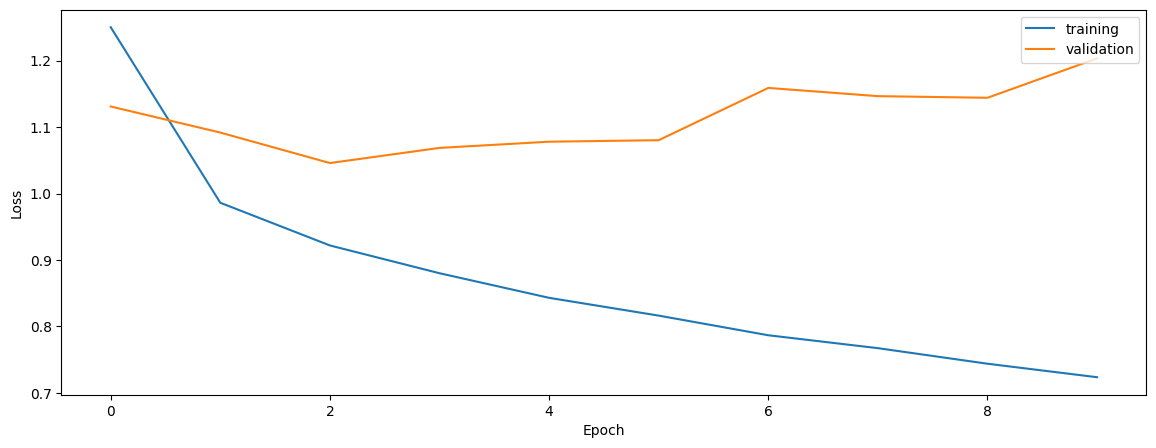

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['threshold'] = 0.6
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_1_0_0_1_1_t1t2_normalized_e_n_e_0_0_e_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1254584, 828)
(1254584, 1)
validation
(166224, 828)
(166224, 1)
test
(164640, 828)
(164640, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 828)]             0         


 dense_5 (Dense)             (None, 1024)              848896    


 dense_6 (Dense)             (None, 512)               524800    


 dense_7 (Dense)             (None, 256)               131328    


 dense_8 (Dense)             (None, 128)               32896     


 dense_9 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

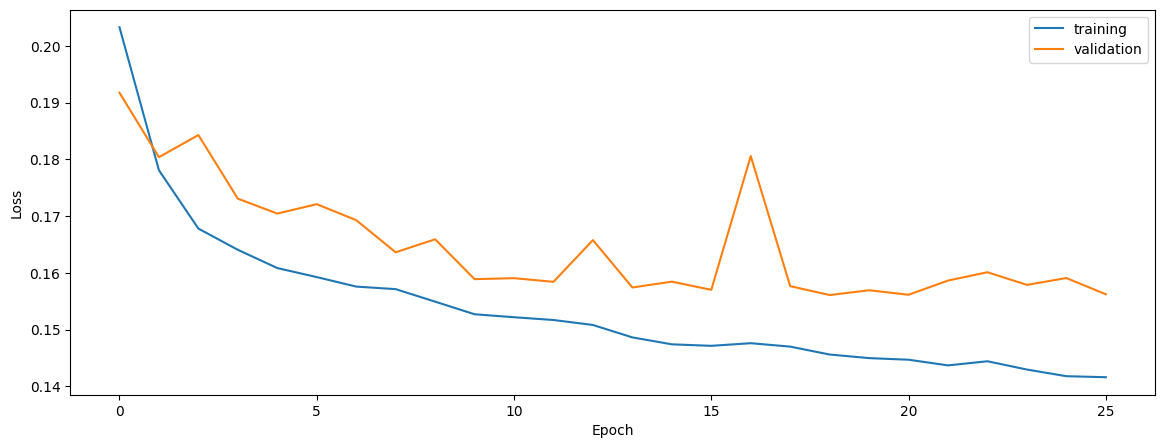

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
import numpy as np

def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['not_connected'] = True
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1','fe':['k5_b25']}]
    props['balance_data'] = False
    props['include_warp'] = True
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    not_connected = np.where(reg < threshold, 1, 0)
    not_connected = np.expand_dims(not_connected,-1)
    pred = np.concatenate([pred,not_connected],-1)
    for i in range(cla.shape[-1]):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print('normalized')
print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

normalized
0.6447123799857071
0.6136417509481669
0.6287820564679233


In [16]:
print('native')
print(getAccuarcy(train_true[1][train_true[2]],train_pred[train_true[2]]))
print(getAccuarcy(val_true[1][val_true[2]],val_pred[val_true[2]]))
print(getAccuarcy(test_true[1][test_true[2]],test_pred[test_true[2]]))

native
0.6417670113948096
0.6211645226811103
0.6346002679273275


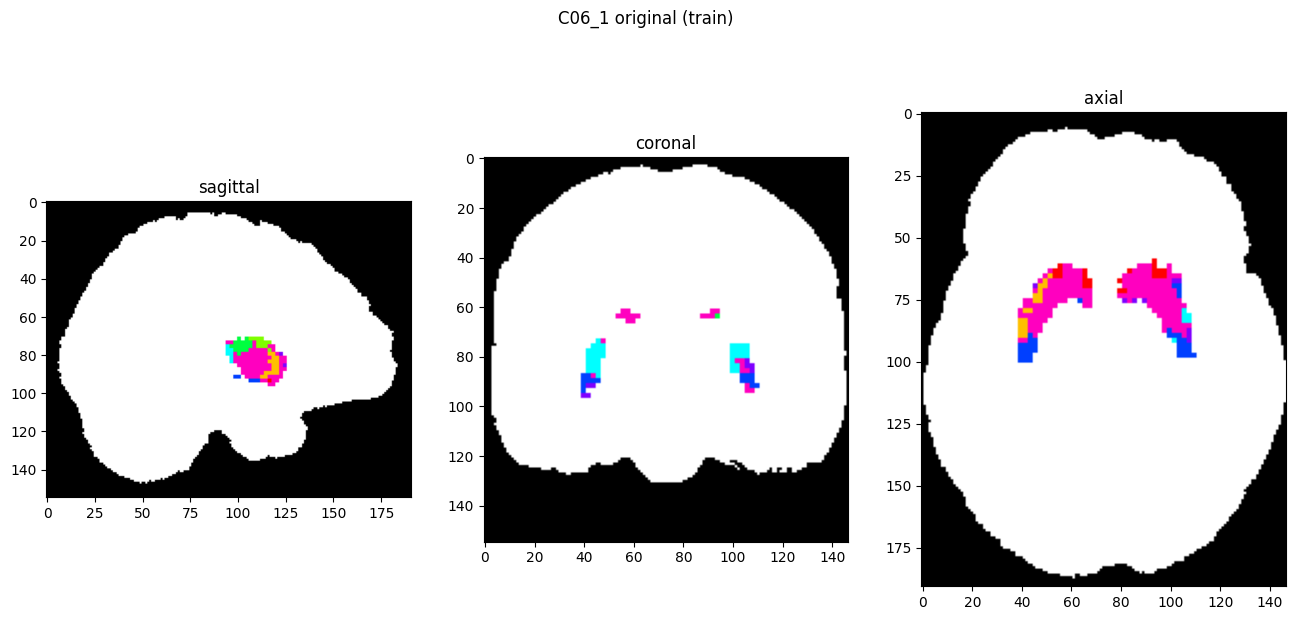

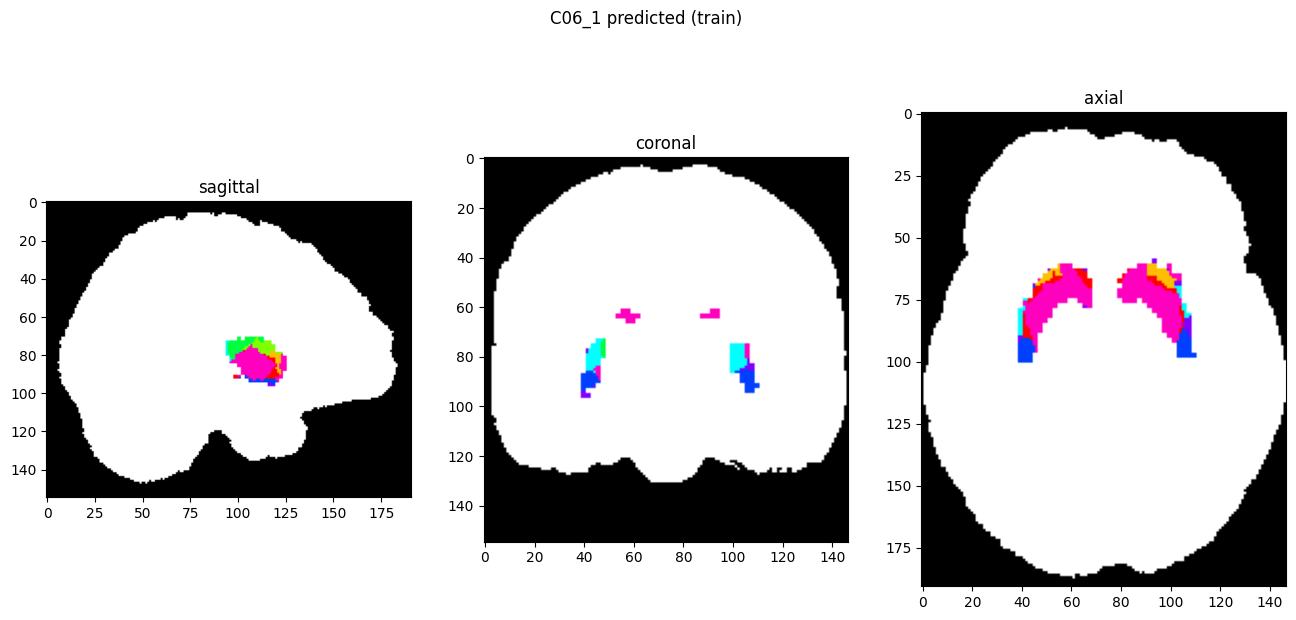

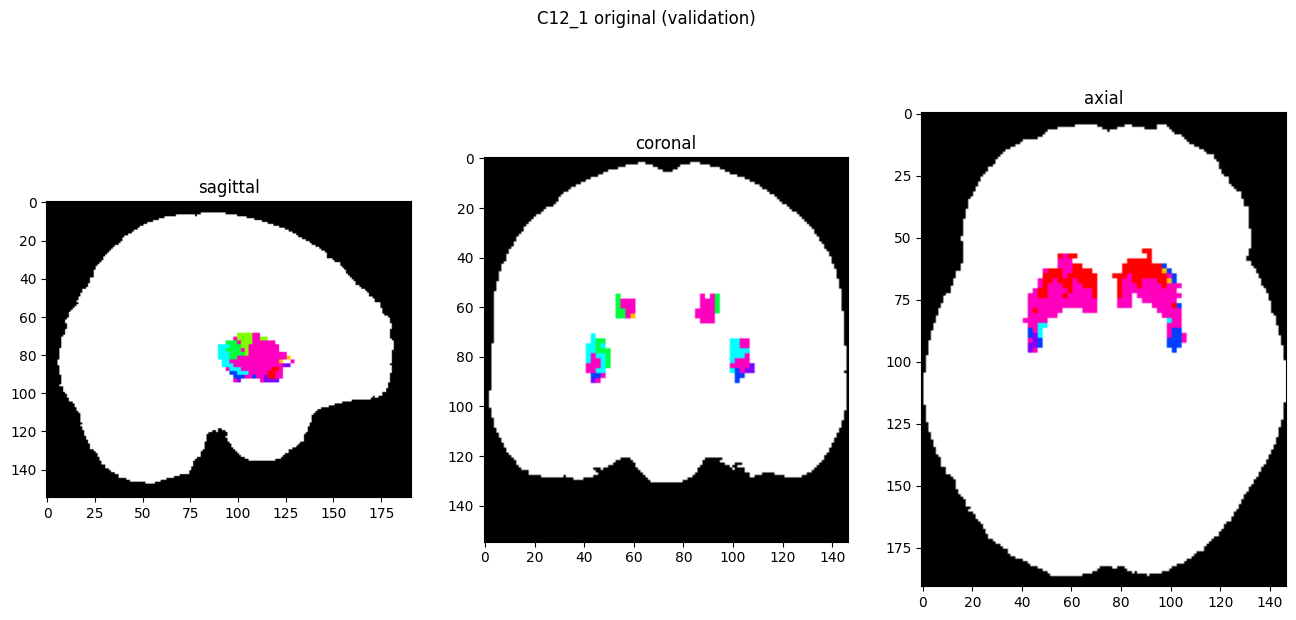

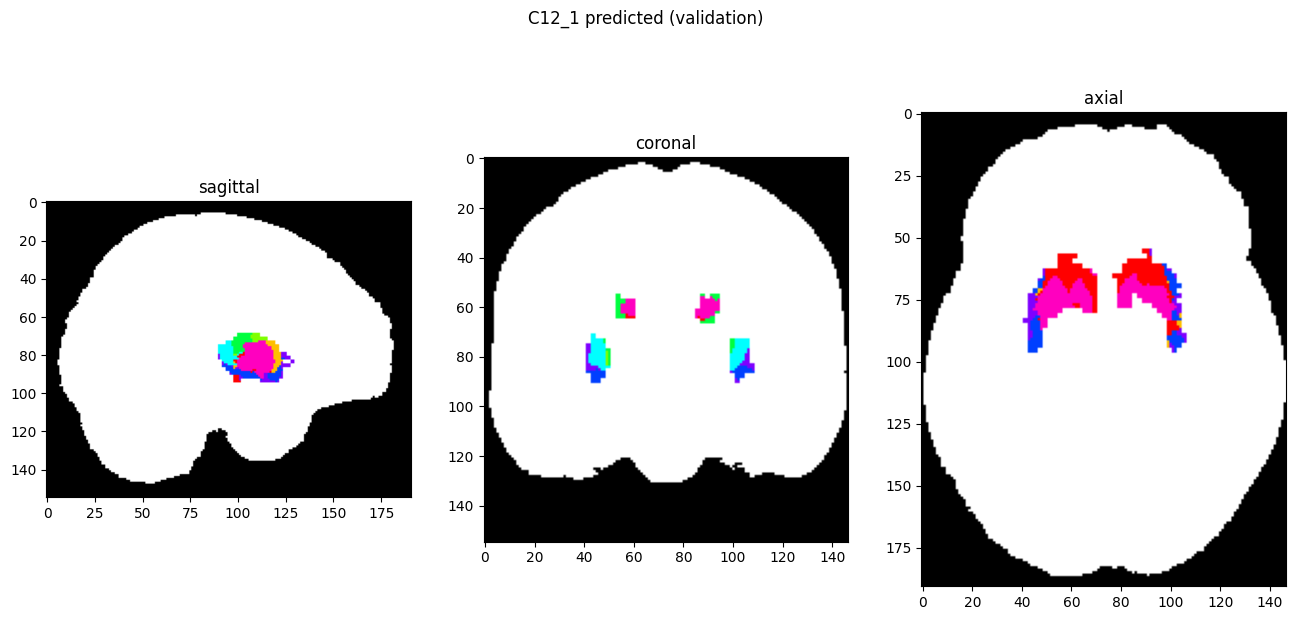

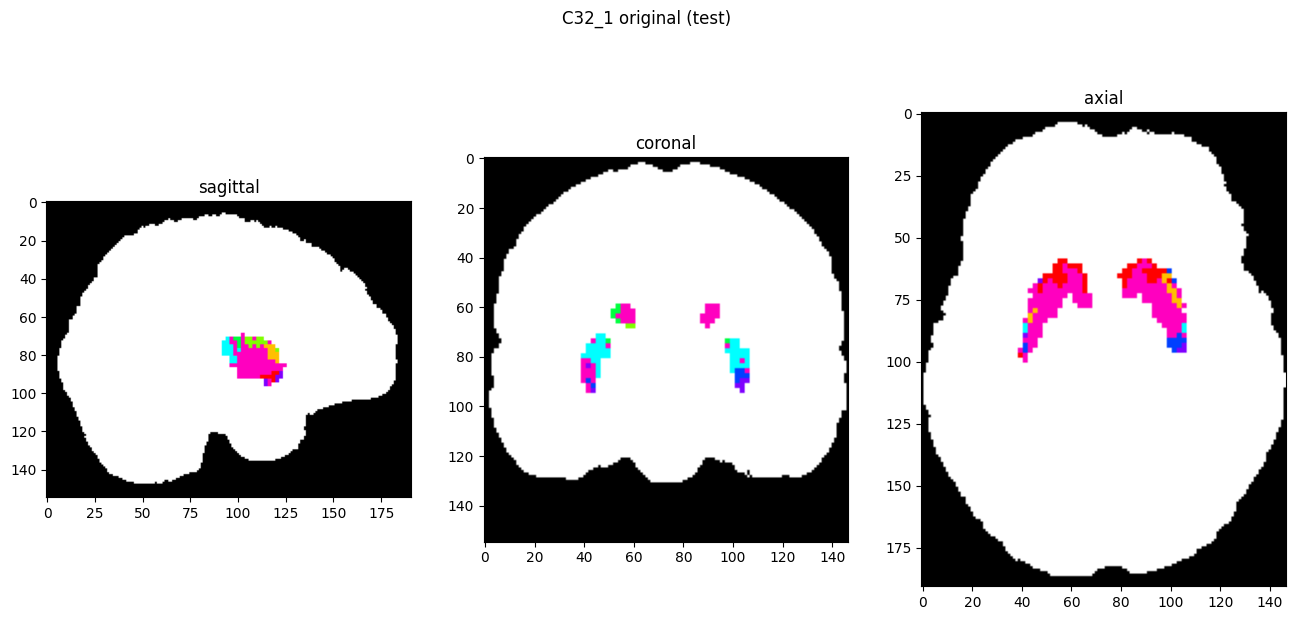

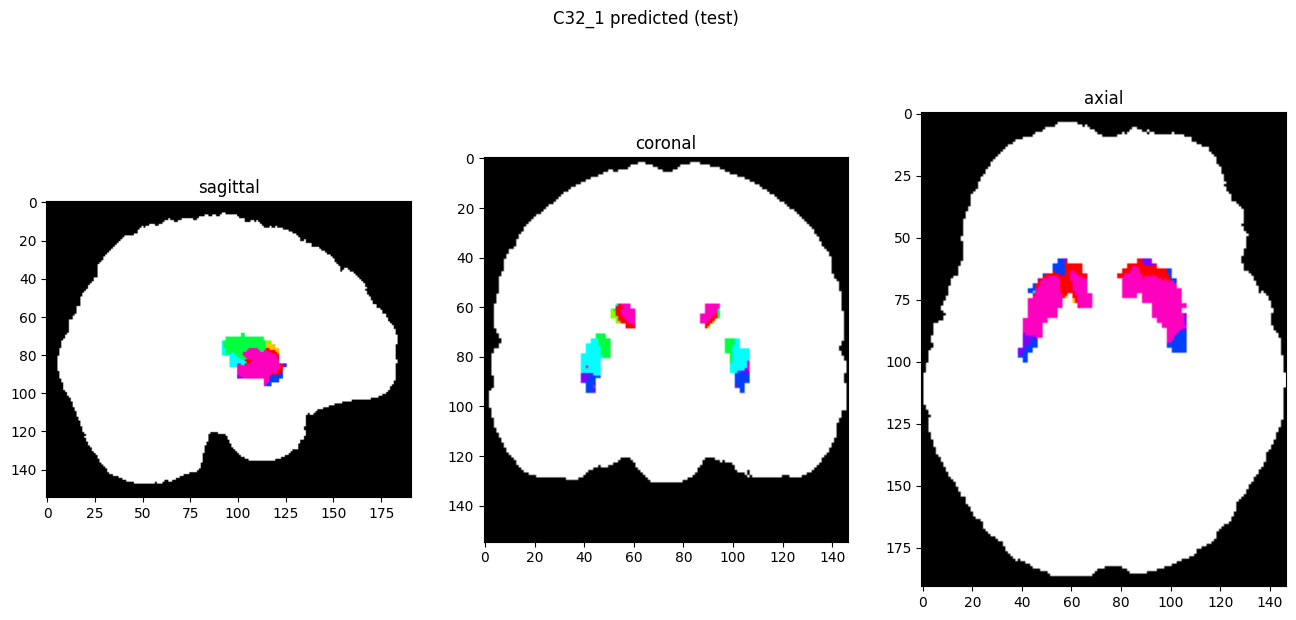

In [17]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)